In [1]:
import pybedtools as pbt
import pysam
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from sklearn.linear_model import LinearRegression
import csv
from keras.models import load_model
from pkg_resources import resource_filename
from spliceai.utils import one_hot_encode
from maxentpy import maxent

Using TensorFlow backend.


In [2]:
import altair as alt
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [3]:
import os.path as op

In [4]:
import seaborn as sns

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import splanl.junction_scorer as jn
import splanl.merge_bcs as mbcs
import splanl.coords as cds
import splanl.plots as sp
import splanl.score_motifs as sm
import splanl.inspect_variants as iv
import splanl.post_processing as pp
import splanl.custom_splai_scores as css
import splanl.create_vcf as vcf

In [7]:
chr11 = '/nfs/kitzman3/lab_common/refs/human/ucsc_hg19/bychrom/chr11.fa'
chr11_seq = pp.get_refseq( chr11 )[ 0 ]

In [8]:
isos_in = '/nfs/kitzman2/smithcat/proj/wt1_2022/ex9_data/'

In [9]:
isos_df = pd.read_table( isos_in + 'wt1_ex9_isoforms_2022-0607.txt' )

In [10]:
isos_df = isos_df.set_index( 'isonum' )

In [11]:
bdout = isos_in

In [12]:
bam1 = ! ls /nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_test*/*out.wbcs.bam

In [13]:
bam2 = ! ls /nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_RT*/*out.wbcs.bam

In [14]:
bam = bam1 + bam2

In [15]:
msamp_fn = { b.split( '/')[ -1 ].split( '.' )[ 0 ].replace( 'Aligned', '' ) : b for b in bam }

In [16]:
isogrpdict = { samp: jn.create_iso_dict_no_cnst( isos_df.query( samp + '_filter!=0' ) )
              for samp in msamp_fn }

In [23]:
isogrpdict_allsamp = { isonum: iso for samp in isogrpdict for isonum,iso in isogrpdict[ samp ].items() }

In [24]:
isogrpdict_allsamp

{'iso0054': ((1236, 1359),),
 'iso0218': ((1284, 1350),),
 'iso0732': ((1267, 1293), (1334, 1359)),
 'iso1372': ((1267, 1350),),
 'iso1593': ((1267, 1340), (2171, 2179)),
 'iso1730': ((1267, 1273), (1295, 1350)),
 'iso1880': ((1265, 1359),),
 'iso2334': ((1269, 1359),),
 'iso2380': ((1268, 1350),),
 'iso2657': ((1267, 1359),),
 'iso3932': ((1267, 1289), (1335, 1359)),
 'iso4356': ((1284, 1359),),
 'iso4794': (),
 'iso5582': ((1269, 1350),),
 'iso5986': ((1267, 1347),),
 'iso7316': ((1267, 1314), (1337, 1350)),
 'iso2405': ((1267, 1304), (1336, 1359)),
 'iso5870': ((1305, 1359),),
 'iso0987': ((1267, 1331),),
 'iso3738': ((1268, 1359),),
 'iso4930': ((1270, 1359),),
 'iso0536': ((1236, 1350),),
 'iso2348': ((1266, 1359),),
 'iso2568': ((1266, 1350),),
 'iso4001': ((1267, 1274), (1296, 1350)),
 'iso6359': ((1267, 1321), (1344, 1359)),
 'iso0062': ((1267, 1289), (1335, 1350)),
 'iso0335': ((1267, 1337), (2393, 2399)),
 'iso0405': ((1267, 1293), (1334, 1350)),
 'iso0817': ((1267, 1294), (1

In [25]:
len( isogrpdict_allsamp )

185

In [26]:
satbls = ! ls /nfs/turbo/umms-kitzmanj/oldvol2/jacob/proj/jensplice/20220426_wt1_subasm_filter_stringent/sapipe/sa/*.haps.final.txt

In [27]:
satbl_fn = { sa.split( '/')[ -1 ].split( '.' )[ 0 ]: pd.read_table( sa ).set_index( 'readgroupid' ) for sa in satbls }

In [28]:
for lib in satbl_fn.keys():
    
    satbl_fn[ lib ] = satbl_fn[ lib ][ [ col for col in satbl_fn[ lib ] if not col.startswith( 'nbp_' ) ] ].copy()

In [29]:
msamp_rnabam = { samp: pysam.AlignmentFile(msamp_fn[samp],'rb') for samp in msamp_fn }

In [ ]:
%%time
#52 min
msamp_bcrnatbl = { samp: jn.compute_isoform_counts_pe( msamp_rnabam[ samp ],
                                                               isogrpdict_allsamp,
                                                               [ ( 649, 696 ), ( 3478, 3533 ) ],
                                                               spl_tol = 3,
                                                               indel_tol = 20,
                                                               min_matches_for = 70,
                                                               min_matches_rev = 50,
                                                               #count_otherisos = True,
                                                               bc_tag = 'BC' )
                  for samp in msamp_rnabam }

processed 1000 bcs, 31955 reads
processed 2000 bcs, 67678 reads
processed 3000 bcs, 104625 reads
processed 4000 bcs, 135250 reads
processed 5000 bcs, 175518 reads
processed 6000 bcs, 207177 reads
processed 7000 bcs, 238942 reads
processed 8000 bcs, 271519 reads
processed 9000 bcs, 303319 reads
processed 10000 bcs, 331774 reads
processed 11000 bcs, 365298 reads
processed 12000 bcs, 396164 reads
processed 13000 bcs, 430813 reads
processed 14000 bcs, 466631 reads
processed 15000 bcs, 504354 reads
processed 16000 bcs, 540229 reads
processed 17000 bcs, 571677 reads
processed 18000 bcs, 602486 reads
processed 19000 bcs, 632954 reads
processed 20000 bcs, 662173 reads
processed 21000 bcs, 694710 reads
processed 22000 bcs, 728389 reads
processed 23000 bcs, 764562 reads
processed 24000 bcs, 794577 reads
processed 25000 bcs, 823749 reads
processed 26000 bcs, 853002 reads
processed 27000 bcs, 883973 reads
processed 28000 bcs, 923132 reads
processed 29000 bcs, 952445 reads
processed 30000 bcs, 9810

processed 48000 bcs, 1998514 reads
processed 49000 bcs, 2034694 reads
processed 50000 bcs, 2072721 reads
processed 51000 bcs, 2109191 reads
processed 52000 bcs, 2146187 reads
processed 53000 bcs, 2183385 reads
processed 54000 bcs, 2219502 reads
processed 55000 bcs, 2256225 reads
processed 56000 bcs, 2301572 reads
processed 57000 bcs, 2344283 reads
processed 58000 bcs, 2391325 reads
processed 59000 bcs, 2430996 reads
processed 60000 bcs, 2466397 reads
processed 61000 bcs, 2504715 reads
processed 62000 bcs, 2546412 reads
processed 63000 bcs, 2587576 reads
processed 64000 bcs, 2628066 reads
processed 65000 bcs, 2672189 reads
processed 66000 bcs, 2708442 reads
processed 67000 bcs, 2751320 reads
processed 68000 bcs, 2802716 reads
processed 69000 bcs, 2844785 reads
processed 70000 bcs, 2879736 reads
processed 71000 bcs, 2922430 reads
processed 72000 bcs, 2962407 reads
processed 73000 bcs, 2997286 reads
processed 74000 bcs, 3032055 reads
processed 75000 bcs, 3066313 reads
processed 76000 bcs,

processed 277000 bcs, 11038658 reads
processed 278000 bcs, 11077469 reads
processed 279000 bcs, 11109824 reads
processed 280000 bcs, 11141284 reads
processed 281000 bcs, 11175945 reads
processed 282000 bcs, 11209571 reads
processed 283000 bcs, 11243228 reads
processed 284000 bcs, 11283058 reads
processed 285000 bcs, 11325149 reads
processed 286000 bcs, 11362534 reads
processed 287000 bcs, 11397296 reads
processed 288000 bcs, 11427519 reads
processed 289000 bcs, 11469962 reads
processed 290000 bcs, 11505601 reads
processed 291000 bcs, 11541272 reads
processed 292000 bcs, 11611655 reads
processed 293000 bcs, 11648007 reads
processed 294000 bcs, 11681141 reads
processed 295000 bcs, 11715628 reads
processed 296000 bcs, 11751062 reads
processed 297000 bcs, 11789538 reads
processed 298000 bcs, 11825277 reads
processed 299000 bcs, 11866859 reads
processed 300000 bcs, 11897612 reads
processed 301000 bcs, 11929794 reads
processed 302000 bcs, 11965974 reads
processed 303000 bcs, 11998178 reads
p

processed 4000 bcs, 157958 reads
processed 5000 bcs, 208340 reads
processed 6000 bcs, 241302 reads
processed 7000 bcs, 281265 reads
processed 8000 bcs, 319136 reads
processed 9000 bcs, 370242 reads
processed 10000 bcs, 410620 reads
processed 11000 bcs, 451785 reads
processed 12000 bcs, 494853 reads
processed 13000 bcs, 533429 reads
processed 14000 bcs, 572516 reads
processed 15000 bcs, 610894 reads
processed 16000 bcs, 644642 reads
processed 17000 bcs, 684113 reads
processed 18000 bcs, 721415 reads
processed 19000 bcs, 760106 reads
processed 20000 bcs, 793042 reads
processed 21000 bcs, 824260 reads
processed 22000 bcs, 856629 reads
processed 23000 bcs, 908326 reads
processed 24000 bcs, 942831 reads
processed 25000 bcs, 978276 reads
processed 26000 bcs, 1011561 reads
processed 27000 bcs, 1050808 reads
processed 28000 bcs, 1100019 reads
processed 29000 bcs, 1135592 reads
processed 30000 bcs, 1178636 reads
processed 31000 bcs, 1220662 reads
processed 32000 bcs, 1258624 reads
processed 330

processed 236000 bcs, 8771705 reads
processed 237000 bcs, 8815144 reads
processed 238000 bcs, 8846300 reads
processed 239000 bcs, 8878960 reads
processed 240000 bcs, 8912449 reads
processed 241000 bcs, 8945714 reads
processed 242000 bcs, 8984001 reads
processed 243000 bcs, 9015990 reads
processed 244000 bcs, 9052440 reads
processed 245000 bcs, 9122829 reads
processed 246000 bcs, 9157737 reads
processed 247000 bcs, 9189153 reads
processed 248000 bcs, 9219563 reads
processed 249000 bcs, 9257866 reads
processed 250000 bcs, 9289470 reads
processed 251000 bcs, 9323891 reads
processed 252000 bcs, 9377115 reads
processed 253000 bcs, 9416331 reads
processed 254000 bcs, 9452280 reads
processed 255000 bcs, 9497455 reads
processed 256000 bcs, 9530488 reads
processed 257000 bcs, 9565223 reads
processed 258000 bcs, 9595371 reads
processed 259000 bcs, 9636719 reads
processed 260000 bcs, 9666825 reads
processed 261000 bcs, 9701209 reads
processed 262000 bcs, 9743212 reads
processed 263000 bcs, 977933

processed 33000 bcs, 656428 reads
processed 34000 bcs, 675284 reads
processed 35000 bcs, 694681 reads
processed 36000 bcs, 713502 reads
processed 37000 bcs, 732092 reads
processed 38000 bcs, 750656 reads
processed 39000 bcs, 769489 reads
processed 40000 bcs, 788714 reads
processed 41000 bcs, 806451 reads
processed 42000 bcs, 825288 reads
processed 43000 bcs, 843956 reads
processed 44000 bcs, 863264 reads
processed 45000 bcs, 879929 reads
processed 46000 bcs, 898755 reads
processed 47000 bcs, 918692 reads
processed 48000 bcs, 936986 reads
processed 49000 bcs, 956329 reads
processed 50000 bcs, 976662 reads
processed 51000 bcs, 998217 reads
processed 52000 bcs, 1017184 reads
processed 53000 bcs, 1036573 reads
processed 54000 bcs, 1055007 reads
processed 55000 bcs, 1073607 reads
processed 56000 bcs, 1092813 reads
processed 57000 bcs, 1111963 reads
processed 58000 bcs, 1131430 reads
processed 59000 bcs, 1150011 reads
processed 60000 bcs, 1170382 reads
processed 61000 bcs, 1188879 reads
proc

processed 17000 bcs, 181770 reads
processed 18000 bcs, 193303 reads
processed 19000 bcs, 204545 reads
processed 20000 bcs, 215405 reads
processed 21000 bcs, 226866 reads
processed 22000 bcs, 238772 reads
processed 23000 bcs, 251070 reads
processed 24000 bcs, 262204 reads
processed 25000 bcs, 271143 reads
processed 26000 bcs, 280471 reads
processed 27000 bcs, 290796 reads
processed 28000 bcs, 300562 reads
processed 29000 bcs, 310391 reads
processed 30000 bcs, 320277 reads
processed 31000 bcs, 329715 reads
processed 32000 bcs, 339305 reads
processed 33000 bcs, 348460 reads
processed 34000 bcs, 359310 reads
processed 35000 bcs, 370377 reads
processed 36000 bcs, 380619 reads
processed 37000 bcs, 391316 reads
processed 38000 bcs, 401797 reads
processed 39000 bcs, 411115 reads
processed 40000 bcs, 420197 reads
processed 41000 bcs, 429829 reads
processed 42000 bcs, 440503 reads
processed 43000 bcs, 449877 reads
processed 44000 bcs, 459159 reads
processed 45000 bcs, 469677 reads
processed 4600

processed 250000 bcs, 2612450 reads
processed 251000 bcs, 2624140 reads
processed 252000 bcs, 2635010 reads
processed 253000 bcs, 2645184 reads
processed 254000 bcs, 2654151 reads
processed 255000 bcs, 2663841 reads
processed 256000 bcs, 2673077 reads
processed 257000 bcs, 2681670 reads
processed 258000 bcs, 2690413 reads
processed 259000 bcs, 2699665 reads
processed 260000 bcs, 2709276 reads
processed 261000 bcs, 2717857 reads
processed 262000 bcs, 2725604 reads
processed 263000 bcs, 2734059 reads
processed 264000 bcs, 2742829 reads
processed 265000 bcs, 2752172 reads
processed 266000 bcs, 2762530 reads
processed 267000 bcs, 2772846 reads
processed 268000 bcs, 2782076 reads
processed 269000 bcs, 2791275 reads
processed 270000 bcs, 2800835 reads
processed 271000 bcs, 2811324 reads
processed 272000 bcs, 2821936 reads
processed 273000 bcs, 2831255 reads
processed 274000 bcs, 2840136 reads
processed 275000 bcs, 2849448 reads
processed 276000 bcs, 2858187 reads
processed 277000 bcs, 286686

processed 478000 bcs, 5136095 reads
processed 479000 bcs, 5148204 reads
processed 480000 bcs, 5159293 reads
processed 481000 bcs, 5169039 reads
processed 482000 bcs, 5180513 reads
processed 483000 bcs, 5192127 reads
processed 484000 bcs, 5204557 reads
processed 485000 bcs, 5217275 reads
processed 486000 bcs, 5228534 reads
processed 487000 bcs, 5240410 reads
processed 488000 bcs, 5251949 reads
processed 489000 bcs, 5262580 reads
processed 490000 bcs, 5274727 reads
processed 491000 bcs, 5285047 reads
processed 492000 bcs, 5294294 reads
processed 493000 bcs, 5303730 reads
processed 494000 bcs, 5313934 reads
processed 495000 bcs, 5323207 reads
processed 496000 bcs, 5333136 reads
processed 497000 bcs, 5342766 reads
processed 498000 bcs, 5353759 reads
processed 499000 bcs, 5364907 reads
processed 500000 bcs, 5375010 reads
processed 501000 bcs, 5384852 reads
processed 502000 bcs, 5394258 reads
processed 503000 bcs, 5403888 reads
processed 504000 bcs, 5414583 reads
processed 505000 bcs, 542540

processed 706000 bcs, 7466838 reads
processed 707000 bcs, 7476026 reads
processed 708000 bcs, 7486523 reads
processed 709000 bcs, 7494828 reads
processed 710000 bcs, 7502969 reads
processed 711000 bcs, 7512247 reads
processed 712000 bcs, 7522561 reads
processed 713000 bcs, 7530835 reads
processed 714000 bcs, 7539928 reads
processed 715000 bcs, 7548815 reads
processed 716000 bcs, 7559288 reads
processed 717000 bcs, 7570011 reads
processed 718000 bcs, 7579456 reads
processed 719000 bcs, 7589343 reads
processed 720000 bcs, 7598785 reads
processed 721000 bcs, 7608717 reads
processed 722000 bcs, 7618846 reads
processed 723000 bcs, 7627614 reads
processed 724000 bcs, 7636089 reads
processed 725000 bcs, 7644143 reads
processed 726000 bcs, 7652666 reads
processed 727000 bcs, 7661128 reads
processed 728000 bcs, 7669608 reads
processed 729000 bcs, 7679563 reads
processed 730000 bcs, 7689841 reads
processed 731000 bcs, 7698164 reads
processed 732000 bcs, 7706725 reads
processed 733000 bcs, 771507

processed 131000 bcs, 3854951 reads
processed 132000 bcs, 3887034 reads
processed 133000 bcs, 3911939 reads
processed 134000 bcs, 3939830 reads
processed 135000 bcs, 3970958 reads
processed 136000 bcs, 4002451 reads
processed 137000 bcs, 4030741 reads
processed 138000 bcs, 4056431 reads
processed 139000 bcs, 4080377 reads
processed 140000 bcs, 4108592 reads
processed 141000 bcs, 4135701 reads
processed 142000 bcs, 4161006 reads
processed 143000 bcs, 4185600 reads
processed 144000 bcs, 4213395 reads
processed 145000 bcs, 4239460 reads
processed 146000 bcs, 4263115 reads
processed 147000 bcs, 4288906 reads
processed 148000 bcs, 4316200 reads
processed 149000 bcs, 4342994 reads
processed 150000 bcs, 4373483 reads
processed 151000 bcs, 4403332 reads
processed 152000 bcs, 4429088 reads
processed 153000 bcs, 4457533 reads
processed 154000 bcs, 4502460 reads
processed 155000 bcs, 4536620 reads
processed 156000 bcs, 4562890 reads
processed 157000 bcs, 4589007 reads
processed 158000 bcs, 461259

processed 203000 bcs, 2317378 reads
processed 204000 bcs, 2327283 reads
processed 205000 bcs, 2337172 reads
processed 206000 bcs, 2346857 reads
processed 207000 bcs, 2355056 reads
processed 208000 bcs, 2364232 reads
processed 209000 bcs, 2374251 reads
processed 210000 bcs, 2383461 reads
processed 211000 bcs, 2391632 reads
processed 212000 bcs, 2400569 reads
processed 213000 bcs, 2409063 reads
processed 214000 bcs, 2421256 reads
processed 215000 bcs, 2434697 reads
processed 216000 bcs, 2449987 reads
processed 217000 bcs, 2464779 reads
processed 218000 bcs, 2480819 reads
processed 219000 bcs, 2492762 reads
processed 220000 bcs, 2507596 reads
processed 221000 bcs, 2522145 reads
processed 222000 bcs, 2535751 reads
processed 223000 bcs, 2551446 reads
processed 224000 bcs, 2564319 reads
processed 225000 bcs, 2579948 reads
processed 226000 bcs, 2596434 reads
processed 227000 bcs, 2612163 reads
processed 228000 bcs, 2625261 reads
processed 229000 bcs, 2639345 reads
processed 230000 bcs, 265137

processed 431000 bcs, 5226709 reads
processed 432000 bcs, 5237723 reads
processed 433000 bcs, 5247628 reads
processed 434000 bcs, 5257304 reads
processed 435000 bcs, 5265890 reads
processed 436000 bcs, 5273719 reads
processed 437000 bcs, 5283969 reads
processed 438000 bcs, 5292008 reads
processed 439000 bcs, 5301130 reads
processed 440000 bcs, 5309507 reads
processed 441000 bcs, 5318420 reads
processed 442000 bcs, 5325858 reads
processed 443000 bcs, 5335242 reads
processed 444000 bcs, 5344118 reads
processed 445000 bcs, 5353385 reads
processed 446000 bcs, 5363646 reads
processed 447000 bcs, 5373996 reads
processed 448000 bcs, 5383970 reads
processed 449000 bcs, 5392983 reads
processed 450000 bcs, 5401616 reads
processed 451000 bcs, 5410857 reads
processed 452000 bcs, 5419533 reads
processed 453000 bcs, 5429079 reads
processed 454000 bcs, 5440737 reads
processed 455000 bcs, 5453383 reads
processed 456000 bcs, 5466525 reads
processed 457000 bcs, 5477954 reads
processed 458000 bcs, 549067

processed 63000 bcs, 507872 reads
processed 64000 bcs, 516688 reads
processed 65000 bcs, 524460 reads
processed 66000 bcs, 533788 reads
processed 67000 bcs, 543312 reads
processed 68000 bcs, 553181 reads
processed 69000 bcs, 562700 reads
processed 70000 bcs, 572563 reads
processed 71000 bcs, 582607 reads
processed 72000 bcs, 591225 reads
processed 73000 bcs, 600982 reads
processed 74000 bcs, 610116 reads
processed 75000 bcs, 619308 reads
processed 76000 bcs, 628883 reads
processed 77000 bcs, 637771 reads
processed 78000 bcs, 645989 reads
processed 79000 bcs, 654604 reads
processed 80000 bcs, 663270 reads
processed 81000 bcs, 672176 reads
processed 82000 bcs, 681120 reads
processed 83000 bcs, 690106 reads
processed 84000 bcs, 698154 reads
processed 85000 bcs, 706642 reads
processed 86000 bcs, 715831 reads
processed 87000 bcs, 724455 reads
processed 88000 bcs, 732799 reads
processed 89000 bcs, 741400 reads
processed 90000 bcs, 750249 reads
processed 91000 bcs, 758500 reads
processed 9200

processed 295000 bcs, 2366400 reads
processed 296000 bcs, 2374081 reads
processed 297000 bcs, 2381793 reads
processed 298000 bcs, 2388848 reads
processed 299000 bcs, 2395643 reads
processed 300000 bcs, 2402564 reads
processed 301000 bcs, 2410070 reads
processed 302000 bcs, 2417266 reads
processed 303000 bcs, 2423276 reads
processed 304000 bcs, 2429638 reads
processed 305000 bcs, 2436797 reads
processed 306000 bcs, 2443532 reads
processed 307000 bcs, 2450830 reads
processed 308000 bcs, 2458701 reads
processed 309000 bcs, 2466607 reads
processed 310000 bcs, 2473635 reads
processed 311000 bcs, 2481049 reads
processed 312000 bcs, 2488487 reads
processed 313000 bcs, 2495539 reads
processed 314000 bcs, 2504135 reads
processed 315000 bcs, 2512220 reads
processed 316000 bcs, 2519827 reads
processed 317000 bcs, 2526900 reads
processed 318000 bcs, 2533667 reads
processed 319000 bcs, 2540622 reads
processed 320000 bcs, 2547863 reads
processed 321000 bcs, 2554397 reads
processed 322000 bcs, 256063

processed 523000 bcs, 4334575 reads
processed 524000 bcs, 4342292 reads
processed 525000 bcs, 4349911 reads
processed 526000 bcs, 4357148 reads
processed 527000 bcs, 4364752 reads
processed 528000 bcs, 4371724 reads
processed 529000 bcs, 4379262 reads
processed 530000 bcs, 4385917 reads
processed 531000 bcs, 4391518 reads
processed 532000 bcs, 4399334 reads
processed 533000 bcs, 4406891 reads
processed 534000 bcs, 4413526 reads
processed 535000 bcs, 4420831 reads
processed 536000 bcs, 4427529 reads
processed 537000 bcs, 4436193 reads
processed 538000 bcs, 4444138 reads
processed 539000 bcs, 4452092 reads
processed 540000 bcs, 4459617 reads
processed 541000 bcs, 4468115 reads
processed 542000 bcs, 4476659 reads
processed 543000 bcs, 4485416 reads
processed 544000 bcs, 4494181 reads
processed 545000 bcs, 4502465 reads
processed 546000 bcs, 4511225 reads
processed 547000 bcs, 4519600 reads
processed 548000 bcs, 4527291 reads
processed 549000 bcs, 4535717 reads
processed 550000 bcs, 454340

processed 752000 bcs, 6166298 reads
processed 753000 bcs, 6174059 reads
processed 754000 bcs, 6182664 reads
processed 755000 bcs, 6191117 reads
processed 756000 bcs, 6199302 reads
processed 757000 bcs, 6207175 reads
processed 758000 bcs, 6214534 reads
processed 759000 bcs, 6223167 reads
processed 760000 bcs, 6231283 reads
processed 761000 bcs, 6239379 reads
processed 762000 bcs, 6248098 reads
processed 763000 bcs, 6257290 reads
processed 764000 bcs, 6265378 reads
processed 765000 bcs, 6274754 reads
processed 766000 bcs, 6283956 reads
processed 767000 bcs, 6292457 reads
processed 768000 bcs, 6300085 reads
processed 769000 bcs, 6308657 reads
processed 770000 bcs, 6318138 reads
processed 771000 bcs, 6326304 reads
processed 772000 bcs, 6334362 reads
processed 773000 bcs, 6342412 reads
processed 774000 bcs, 6350359 reads
processed 775000 bcs, 6358704 reads
processed 776000 bcs, 6367398 reads
processed 777000 bcs, 6376080 reads
processed 778000 bcs, 6384433 reads
processed 779000 bcs, 639272

processed 59000 bcs, 701202 reads
processed 60000 bcs, 712360 reads
processed 61000 bcs, 724375 reads
processed 62000 bcs, 733897 reads
processed 63000 bcs, 746194 reads
processed 64000 bcs, 758221 reads
processed 65000 bcs, 769051 reads
processed 66000 bcs, 781327 reads
processed 67000 bcs, 793858 reads
processed 68000 bcs, 805256 reads
processed 69000 bcs, 816030 reads
processed 70000 bcs, 828179 reads
processed 71000 bcs, 839448 reads
processed 72000 bcs, 851364 reads
processed 73000 bcs, 863506 reads
processed 74000 bcs, 874002 reads
processed 75000 bcs, 884787 reads
processed 76000 bcs, 894297 reads
processed 77000 bcs, 902560 reads
processed 78000 bcs, 911242 reads
processed 79000 bcs, 921307 reads
processed 80000 bcs, 931595 reads
processed 81000 bcs, 941197 reads
processed 82000 bcs, 951134 reads
processed 83000 bcs, 960280 reads
processed 84000 bcs, 969401 reads
processed 85000 bcs, 978918 reads
processed 86000 bcs, 989451 reads
processed 87000 bcs, 999653 reads
processed 8800

processed 289000 bcs, 3384809 reads
processed 290000 bcs, 3398271 reads
processed 291000 bcs, 3412545 reads
processed 292000 bcs, 3424087 reads
processed 293000 bcs, 3438513 reads
processed 294000 bcs, 3453491 reads
processed 295000 bcs, 3466913 reads
processed 296000 bcs, 3480860 reads
processed 297000 bcs, 3493843 reads
processed 298000 bcs, 3507809 reads
processed 299000 bcs, 3519445 reads
processed 300000 bcs, 3529547 reads
processed 301000 bcs, 3539825 reads
processed 302000 bcs, 3549018 reads
processed 303000 bcs, 3560720 reads
processed 304000 bcs, 3572894 reads
processed 305000 bcs, 3583447 reads
processed 306000 bcs, 3592564 reads
processed 307000 bcs, 3602275 reads
processed 308000 bcs, 3611611 reads
processed 309000 bcs, 3623932 reads
processed 310000 bcs, 3637973 reads
processed 311000 bcs, 3650443 reads
processed 312000 bcs, 3663943 reads
processed 313000 bcs, 3676624 reads
processed 314000 bcs, 3688583 reads
processed 315000 bcs, 3698596 reads
processed 316000 bcs, 371181

processed 517000 bcs, 5921393 reads
processed 518000 bcs, 5930286 reads
processed 519000 bcs, 5938312 reads
processed 520000 bcs, 5946993 reads
processed 521000 bcs, 5956008 reads
processed 522000 bcs, 5965808 reads
processed 523000 bcs, 5973834 reads
processed 524000 bcs, 5982543 reads
processed 525000 bcs, 5993991 reads
processed 526000 bcs, 6004733 reads
processed 527000 bcs, 6015175 reads
processed 528000 bcs, 6026440 reads
processed 529000 bcs, 6038103 reads
processed 530000 bcs, 6050829 reads
processed 531000 bcs, 6061731 reads
processed 532000 bcs, 6072170 reads
processed 533000 bcs, 6083815 reads
processed 534000 bcs, 6093627 reads
processed 535000 bcs, 6103517 reads
processed 536000 bcs, 6113995 reads
processed 537000 bcs, 6124031 reads
processed 538000 bcs, 6135210 reads
processed 539000 bcs, 6146850 reads
processed 540000 bcs, 6158272 reads
processed 541000 bcs, 6169819 reads
processed 542000 bcs, 6183308 reads
processed 543000 bcs, 6194054 reads
processed 544000 bcs, 620502

processed 183000 bcs, 1590013 reads
processed 184000 bcs, 1598379 reads
processed 185000 bcs, 1606549 reads
processed 186000 bcs, 1614433 reads
processed 187000 bcs, 1622323 reads
processed 188000 bcs, 1629622 reads
processed 189000 bcs, 1638084 reads
processed 190000 bcs, 1647167 reads
processed 191000 bcs, 1654819 reads
processed 192000 bcs, 1662388 reads
processed 193000 bcs, 1670353 reads
processed 194000 bcs, 1678351 reads
processed 195000 bcs, 1686085 reads
processed 196000 bcs, 1694214 reads
processed 197000 bcs, 1702659 reads
processed 198000 bcs, 1709761 reads
processed 199000 bcs, 1716038 reads
processed 200000 bcs, 1722947 reads
processed 201000 bcs, 1730305 reads
processed 202000 bcs, 1739299 reads
processed 203000 bcs, 1747689 reads
processed 204000 bcs, 1754727 reads
processed 205000 bcs, 1762651 reads
processed 206000 bcs, 1769916 reads
processed 207000 bcs, 1777528 reads
processed 208000 bcs, 1785480 reads
processed 209000 bcs, 1794000 reads
processed 210000 bcs, 180313

processed 412000 bcs, 3651656 reads
processed 413000 bcs, 3660460 reads
processed 414000 bcs, 3669094 reads
processed 415000 bcs, 3677476 reads
processed 416000 bcs, 3685684 reads
processed 417000 bcs, 3694703 reads
processed 418000 bcs, 3701900 reads
processed 419000 bcs, 3710086 reads
processed 420000 bcs, 3718914 reads
processed 421000 bcs, 3727930 reads
processed 422000 bcs, 3736497 reads
processed 423000 bcs, 3745536 reads
processed 424000 bcs, 3754178 reads
processed 425000 bcs, 3761892 reads
processed 426000 bcs, 3769593 reads
processed 427000 bcs, 3776751 reads
processed 428000 bcs, 3784735 reads
processed 429000 bcs, 3792542 reads
processed 430000 bcs, 3800420 reads
processed 431000 bcs, 3809274 reads
processed 432000 bcs, 3817115 reads
processed 433000 bcs, 3825474 reads
processed 434000 bcs, 3833103 reads
processed 435000 bcs, 3842120 reads
processed 436000 bcs, 3850701 reads
processed 437000 bcs, 3858893 reads
processed 438000 bcs, 3868409 reads
processed 439000 bcs, 387736

processed 641000 bcs, 5614990 reads
processed 642000 bcs, 5623509 reads
processed 643000 bcs, 5630921 reads
processed 644000 bcs, 5638309 reads
processed 645000 bcs, 5646007 reads
processed 646000 bcs, 5654169 reads
processed 647000 bcs, 5663208 reads
processed 648000 bcs, 5671752 reads
processed 649000 bcs, 5679671 reads
processed 650000 bcs, 5688866 reads
processed 651000 bcs, 5697517 reads
processed 652000 bcs, 5706517 reads
processed 653000 bcs, 5715099 reads
processed 654000 bcs, 5722811 reads
processed 655000 bcs, 5731377 reads
processed 656000 bcs, 5739211 reads
processed 657000 bcs, 5747386 reads
processed 658000 bcs, 5754989 reads
processed 659000 bcs, 5764129 reads
processed 660000 bcs, 5772684 reads
processed 661000 bcs, 5782069 reads
processed 662000 bcs, 5790582 reads
processed 663000 bcs, 5798347 reads
processed 664000 bcs, 5806035 reads
processed 665000 bcs, 5814634 reads
processed 666000 bcs, 5821642 reads
processed 667000 bcs, 5828917 reads
processed 668000 bcs, 583730

processed 121000 bcs, 853493 reads
processed 122000 bcs, 859832 reads
processed 123000 bcs, 865750 reads
processed 124000 bcs, 871946 reads
processed 125000 bcs, 877798 reads
processed 126000 bcs, 884204 reads
processed 127000 bcs, 890986 reads
processed 128000 bcs, 896101 reads
processed 129000 bcs, 901803 reads
processed 130000 bcs, 908277 reads
processed 131000 bcs, 914319 reads
processed 132000 bcs, 919565 reads
processed 133000 bcs, 924849 reads
processed 134000 bcs, 931158 reads
processed 135000 bcs, 938389 reads
processed 136000 bcs, 944340 reads
processed 137000 bcs, 949665 reads
processed 138000 bcs, 956616 reads
processed 139000 bcs, 963390 reads
processed 140000 bcs, 969587 reads
processed 141000 bcs, 977251 reads
processed 142000 bcs, 984244 reads
processed 143000 bcs, 991797 reads
processed 144000 bcs, 998208 reads
processed 145000 bcs, 1005750 reads
processed 146000 bcs, 1013086 reads
processed 147000 bcs, 1018544 reads
processed 148000 bcs, 1025564 reads
processed 149000

processed 351000 bcs, 2568996 reads
processed 352000 bcs, 2574029 reads
processed 353000 bcs, 2579111 reads
processed 354000 bcs, 2585383 reads
processed 355000 bcs, 2591855 reads
processed 356000 bcs, 2598110 reads
processed 357000 bcs, 2605227 reads
processed 358000 bcs, 2610839 reads
processed 359000 bcs, 2616899 reads
processed 360000 bcs, 2623078 reads
processed 361000 bcs, 2628863 reads
processed 362000 bcs, 2634724 reads
processed 363000 bcs, 2641780 reads
processed 364000 bcs, 2649811 reads
processed 365000 bcs, 2657823 reads
processed 366000 bcs, 2665147 reads
processed 367000 bcs, 2671972 reads
processed 368000 bcs, 2678481 reads
processed 369000 bcs, 2685072 reads
processed 370000 bcs, 2692521 reads
processed 371000 bcs, 2700143 reads
processed 372000 bcs, 2706875 reads
processed 373000 bcs, 2714466 reads
processed 374000 bcs, 2723194 reads
processed 375000 bcs, 2733019 reads
processed 376000 bcs, 2742254 reads
processed 377000 bcs, 2750420 reads
processed 378000 bcs, 275846

processed 105000 bcs, 2586140 reads
processed 106000 bcs, 2610376 reads
processed 107000 bcs, 2634325 reads
processed 108000 bcs, 2659275 reads
processed 109000 bcs, 2685928 reads
processed 110000 bcs, 2711595 reads
processed 111000 bcs, 2740501 reads
processed 112000 bcs, 2765779 reads
processed 113000 bcs, 2793186 reads
processed 114000 bcs, 2820966 reads
processed 115000 bcs, 2848576 reads
processed 116000 bcs, 2874178 reads
processed 117000 bcs, 2899294 reads
processed 118000 bcs, 2926409 reads
processed 119000 bcs, 2950604 reads
processed 120000 bcs, 2977368 reads
processed 121000 bcs, 3005400 reads
processed 122000 bcs, 3034622 reads
processed 123000 bcs, 3064120 reads
processed 124000 bcs, 3090464 reads
processed 125000 bcs, 3116958 reads
processed 126000 bcs, 3143530 reads
processed 127000 bcs, 3170172 reads
processed 128000 bcs, 3196083 reads
processed 129000 bcs, 3223140 reads
processed 130000 bcs, 3250787 reads
processed 131000 bcs, 3277812 reads
processed 132000 bcs, 330133

processed 79000 bcs, 922435 reads
processed 80000 bcs, 933458 reads
processed 81000 bcs, 943293 reads
processed 82000 bcs, 954881 reads
processed 83000 bcs, 965687 reads
processed 84000 bcs, 976227 reads
processed 85000 bcs, 987616 reads
processed 86000 bcs, 999957 reads
processed 87000 bcs, 1011823 reads
processed 88000 bcs, 1024658 reads
processed 89000 bcs, 1036527 reads
processed 90000 bcs, 1048016 reads
processed 91000 bcs, 1059263 reads
processed 92000 bcs, 1071318 reads
processed 93000 bcs, 1082651 reads
processed 94000 bcs, 1094828 reads
processed 95000 bcs, 1106928 reads
processed 96000 bcs, 1117721 reads
processed 97000 bcs, 1129801 reads
processed 98000 bcs, 1141253 reads
processed 99000 bcs, 1151948 reads
processed 100000 bcs, 1162192 reads
processed 101000 bcs, 1171576 reads
processed 102000 bcs, 1180100 reads
processed 103000 bcs, 1189445 reads
processed 104000 bcs, 1199155 reads
processed 105000 bcs, 1209223 reads
processed 106000 bcs, 1219021 reads
processed 107000 bcs,

processed 308000 bcs, 3398263 reads
processed 309000 bcs, 3408807 reads
processed 310000 bcs, 3420650 reads
processed 311000 bcs, 3431539 reads
processed 312000 bcs, 3442236 reads
processed 313000 bcs, 3455047 reads
processed 314000 bcs, 3467354 reads
processed 315000 bcs, 3479233 reads
processed 316000 bcs, 3491876 reads
processed 317000 bcs, 3505862 reads
processed 318000 bcs, 3518096 reads
processed 319000 bcs, 3530422 reads
processed 320000 bcs, 3542483 reads
processed 321000 bcs, 3553144 reads
processed 322000 bcs, 3565068 reads
processed 323000 bcs, 3577718 reads
processed 324000 bcs, 3588481 reads
processed 325000 bcs, 3600334 reads
processed 326000 bcs, 3611062 reads
processed 327000 bcs, 3625016 reads
processed 328000 bcs, 3638046 reads
processed 329000 bcs, 3652227 reads
processed 330000 bcs, 3665571 reads
processed 331000 bcs, 3677556 reads
processed 332000 bcs, 3690271 reads
processed 333000 bcs, 3702612 reads
processed 334000 bcs, 3715503 reads
processed 335000 bcs, 372748

processed 537000 bcs, 6069074 reads
processed 538000 bcs, 6078982 reads
processed 539000 bcs, 6089947 reads
processed 540000 bcs, 6099381 reads
processed 541000 bcs, 6109368 reads
processed 542000 bcs, 6120643 reads
processed 543000 bcs, 6131067 reads
processed 544000 bcs, 6141451 reads
processed 545000 bcs, 6151595 reads
processed 546000 bcs, 6160298 reads
processed 547000 bcs, 6168977 reads
processed 548000 bcs, 6177804 reads
processed 549000 bcs, 6187245 reads
processed 550000 bcs, 6196440 reads
processed 551000 bcs, 6204877 reads
processed 552000 bcs, 6213412 reads
processed 553000 bcs, 6222052 reads
processed 554000 bcs, 6232051 reads
processed 555000 bcs, 6241593 reads
processed 556000 bcs, 6250124 reads
processed 557000 bcs, 6258655 reads
processed 558000 bcs, 6268927 reads
processed 559000 bcs, 6279697 reads
processed 560000 bcs, 6289180 reads
processed 561000 bcs, 6299989 reads
processed 562000 bcs, 6310736 reads
processed 563000 bcs, 6322417 reads
processed 564000 bcs, 633181

processed 766000 bcs, 8500647 reads
processed 767000 bcs, 8509499 reads
processed 768000 bcs, 8519448 reads
processed 769000 bcs, 8529942 reads
processed 770000 bcs, 8539174 reads
processed 771000 bcs, 8548113 reads
processed 772000 bcs, 8556302 reads
processed 773000 bcs, 8565946 reads
processed 774000 bcs, 8572742 reads
processed 1000 bcs, 25118 reads
processed 2000 bcs, 50493 reads
processed 3000 bcs, 72689 reads
processed 4000 bcs, 96130 reads
processed 5000 bcs, 119179 reads
processed 6000 bcs, 142863 reads
processed 7000 bcs, 166343 reads
processed 8000 bcs, 203761 reads
processed 9000 bcs, 228364 reads
processed 10000 bcs, 252280 reads
processed 11000 bcs, 274051 reads
processed 12000 bcs, 296656 reads
processed 13000 bcs, 318123 reads
processed 14000 bcs, 342448 reads
processed 15000 bcs, 364476 reads
processed 16000 bcs, 386584 reads
processed 17000 bcs, 410518 reads
processed 18000 bcs, 431928 reads
processed 19000 bcs, 452685 reads
processed 20000 bcs, 479933 reads
processed

processed 126000 bcs, 1884716 reads
processed 127000 bcs, 1900175 reads
processed 128000 bcs, 1918823 reads
processed 129000 bcs, 1936321 reads
processed 130000 bcs, 1953708 reads
processed 131000 bcs, 1971621 reads
processed 132000 bcs, 1989300 reads
processed 133000 bcs, 2005098 reads
processed 134000 bcs, 2020514 reads
processed 135000 bcs, 2034569 reads
processed 136000 bcs, 2051471 reads
processed 137000 bcs, 2066176 reads
processed 138000 bcs, 2080811 reads
processed 139000 bcs, 2098822 reads
processed 140000 bcs, 2116540 reads
processed 141000 bcs, 2133337 reads
processed 142000 bcs, 2152028 reads
processed 143000 bcs, 2169927 reads
processed 144000 bcs, 2184331 reads
processed 145000 bcs, 2199425 reads
processed 146000 bcs, 2212365 reads
processed 147000 bcs, 2227538 reads
processed 148000 bcs, 2242349 reads
processed 149000 bcs, 2256762 reads
processed 150000 bcs, 2272093 reads
processed 151000 bcs, 2284192 reads
processed 152000 bcs, 2297681 reads
processed 153000 bcs, 231143

processed 355000 bcs, 5564878 reads
processed 356000 bcs, 5580653 reads
processed 357000 bcs, 5595040 reads
processed 358000 bcs, 5610650 reads
processed 359000 bcs, 5623591 reads
processed 360000 bcs, 5635766 reads
processed 361000 bcs, 5649254 reads
processed 362000 bcs, 5662308 reads
processed 363000 bcs, 5676545 reads
processed 364000 bcs, 5694005 reads
processed 365000 bcs, 5713329 reads
processed 366000 bcs, 5730826 reads
processed 367000 bcs, 5750099 reads
processed 368000 bcs, 5767521 reads
processed 369000 bcs, 5783859 reads
processed 370000 bcs, 5796203 reads
processed 371000 bcs, 5816390 reads
processed 372000 bcs, 5831868 reads
processed 373000 bcs, 5845544 reads
processed 374000 bcs, 5863622 reads
processed 375000 bcs, 5881259 reads
processed 376000 bcs, 5898310 reads
processed 377000 bcs, 5912592 reads
processed 378000 bcs, 5929302 reads
processed 379000 bcs, 5942468 reads
processed 380000 bcs, 5956576 reads
processed 381000 bcs, 5970832 reads
processed 382000 bcs, 598365

processed 583000 bcs, 8974879 reads
processed 584000 bcs, 8989478 reads
processed 585000 bcs, 9005000 reads
processed 586000 bcs, 9020317 reads
processed 587000 bcs, 9034157 reads
processed 588000 bcs, 9050732 reads
processed 589000 bcs, 9066449 reads
processed 590000 bcs, 9082449 reads
processed 591000 bcs, 9096438 reads
processed 592000 bcs, 9109058 reads
processed 593000 bcs, 9123491 reads
processed 594000 bcs, 9135873 reads
processed 595000 bcs, 9150029 reads
processed 596000 bcs, 9165627 reads
processed 597000 bcs, 9181215 reads
processed 598000 bcs, 9196363 reads
processed 599000 bcs, 9212021 reads
processed 600000 bcs, 9224550 reads
processed 601000 bcs, 9239889 reads
processed 602000 bcs, 9250524 reads
processed 603000 bcs, 9261825 reads
processed 604000 bcs, 9275975 reads
processed 605000 bcs, 9287050 reads
processed 606000 bcs, 9298759 reads
processed 607000 bcs, 9311677 reads
processed 608000 bcs, 9325789 reads
processed 609000 bcs, 9338238 reads
processed 610000 bcs, 935171

processed 28000 bcs, 328464 reads
processed 29000 bcs, 340430 reads
processed 30000 bcs, 350649 reads
processed 31000 bcs, 362532 reads
processed 32000 bcs, 375113 reads
processed 33000 bcs, 387954 reads
processed 34000 bcs, 401066 reads
processed 35000 bcs, 413262 reads
processed 36000 bcs, 425960 reads
processed 37000 bcs, 438711 reads
processed 38000 bcs, 450475 reads
processed 39000 bcs, 464745 reads
processed 40000 bcs, 478234 reads
processed 41000 bcs, 493059 reads
processed 42000 bcs, 506199 reads
processed 43000 bcs, 519949 reads
processed 44000 bcs, 534234 reads
processed 45000 bcs, 546998 reads
processed 46000 bcs, 559771 reads
processed 47000 bcs, 572578 reads
processed 48000 bcs, 585089 reads
processed 49000 bcs, 598189 reads
processed 50000 bcs, 611433 reads
processed 51000 bcs, 623733 reads
processed 52000 bcs, 635410 reads
processed 53000 bcs, 647533 reads
processed 54000 bcs, 659926 reads
processed 55000 bcs, 671894 reads
processed 56000 bcs, 683631 reads
processed 5700

processed 260000 bcs, 3060483 reads
processed 261000 bcs, 3072266 reads
processed 262000 bcs, 3084659 reads
processed 263000 bcs, 3098430 reads
processed 264000 bcs, 3111181 reads
processed 265000 bcs, 3124873 reads
processed 266000 bcs, 3138640 reads
processed 267000 bcs, 3152180 reads
processed 268000 bcs, 3165258 reads
processed 269000 bcs, 3178145 reads
processed 270000 bcs, 3191127 reads
processed 271000 bcs, 3204225 reads
processed 272000 bcs, 3217333 reads
processed 273000 bcs, 3230167 reads
processed 274000 bcs, 3243561 reads
processed 275000 bcs, 3255825 reads
processed 276000 bcs, 3267491 reads
processed 277000 bcs, 3278626 reads
processed 278000 bcs, 3289732 reads
processed 279000 bcs, 3301061 reads
processed 280000 bcs, 3312568 reads
processed 281000 bcs, 3322843 reads
processed 282000 bcs, 3334095 reads
processed 283000 bcs, 3344748 reads
processed 284000 bcs, 3356495 reads
processed 285000 bcs, 3368476 reads
processed 286000 bcs, 3380386 reads
processed 287000 bcs, 339212

processed 488000 bcs, 5643959 reads
processed 489000 bcs, 5654498 reads
processed 490000 bcs, 5664579 reads
processed 491000 bcs, 5673751 reads
processed 492000 bcs, 5685139 reads
processed 493000 bcs, 5696587 reads
processed 494000 bcs, 5707001 reads
processed 495000 bcs, 5719162 reads
processed 496000 bcs, 5732350 reads
processed 497000 bcs, 5745281 reads
processed 498000 bcs, 5757073 reads
processed 499000 bcs, 5768842 reads
processed 500000 bcs, 5779679 reads
processed 501000 bcs, 5790156 reads
processed 502000 bcs, 5800612 reads
processed 503000 bcs, 5813615 reads
processed 504000 bcs, 5825497 reads
processed 505000 bcs, 5836754 reads
processed 506000 bcs, 5847363 reads
processed 507000 bcs, 5860075 reads
processed 508000 bcs, 5872210 reads
processed 509000 bcs, 5884944 reads
processed 510000 bcs, 5896223 reads
processed 511000 bcs, 5906810 reads
processed 512000 bcs, 5917002 reads
processed 513000 bcs, 5926776 reads
processed 514000 bcs, 5937809 reads
processed 515000 bcs, 594906

processed 137000 bcs, 2101077 reads
processed 138000 bcs, 2116992 reads
processed 139000 bcs, 2133909 reads
processed 140000 bcs, 2155306 reads
processed 141000 bcs, 2173913 reads
processed 142000 bcs, 2190394 reads
processed 143000 bcs, 2205117 reads
processed 144000 bcs, 2220857 reads
processed 145000 bcs, 2238978 reads
processed 146000 bcs, 2257292 reads
processed 147000 bcs, 2272280 reads
processed 148000 bcs, 2288660 reads
processed 149000 bcs, 2304097 reads
processed 150000 bcs, 2321031 reads
processed 151000 bcs, 2335059 reads
processed 152000 bcs, 2350501 reads
processed 153000 bcs, 2368462 reads
processed 154000 bcs, 2386497 reads
processed 155000 bcs, 2405036 reads
processed 156000 bcs, 2424371 reads
processed 157000 bcs, 2441936 reads
processed 158000 bcs, 2458704 reads
processed 159000 bcs, 2475605 reads
processed 160000 bcs, 2497297 reads
processed 161000 bcs, 2516381 reads
processed 162000 bcs, 2534674 reads
processed 163000 bcs, 2554354 reads
processed 164000 bcs, 257171

processed 366000 bcs, 5802173 reads
processed 367000 bcs, 5818468 reads
processed 368000 bcs, 5835066 reads
processed 369000 bcs, 5848236 reads
processed 370000 bcs, 5860617 reads
processed 371000 bcs, 5872855 reads
processed 372000 bcs, 5882171 reads


In [ ]:
msamp_bcrnatbl_flen = { samp: jn.filter_on_barc_len( msamp_bcrnatbl[ samp ], 30 )
                        for samp in msamp_bcrnatbl }

In [ ]:
msamp_bcrnatbl_flen[ 'BB_test_Cos1053_JKLab0340_MM1B' ]

BB_test_Cos1053_JKLab0340_MM1B


/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


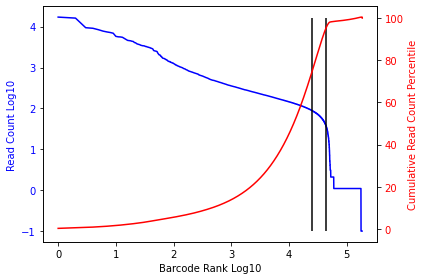

The read count cut off at the 75 th percentile is 87
The read count cut off at the 95 th percentile is 38
BB_test_Cos1053_JKLab0340_MM2B


/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


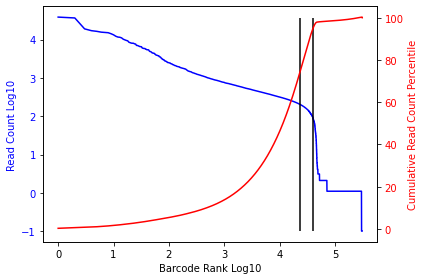

The read count cut off at the 75 th percentile is 200
The read count cut off at the 95 th percentile is 89
BB_test_Cos1053_oligodT_MM1B


/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


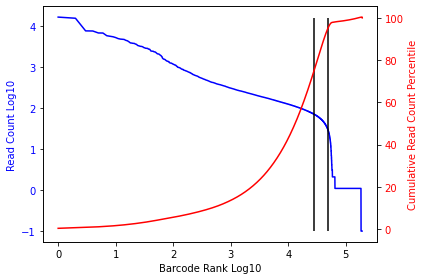

The read count cut off at the 75 th percentile is 71
The read count cut off at the 95 th percentile is 30
BB_test_Cos1053_oligodT_MM2B


/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


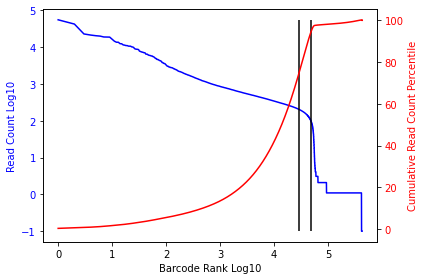

The read count cut off at the 75 th percentile is 203
The read count cut off at the 95 th percentile is 92
BB_RT_1_340_243_Cos1053


/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


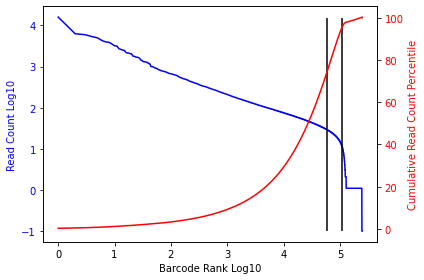

The read count cut off at the 75 th percentile is 29
The read count cut off at the 95 th percentile is 12
BB_RT_1_340_243_Hek1053


/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


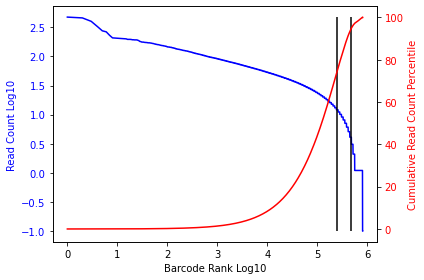

The read count cut off at the 75 th percentile is 12
The read count cut off at the 95 th percentile is 3
BB_RT_1_340_335_Cos1053


/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


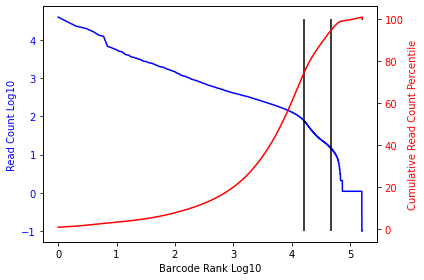

The read count cut off at the 75 th percentile is 74
The read count cut off at the 95 th percentile is 14
BB_RT_1_340_335_Hek1053


/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


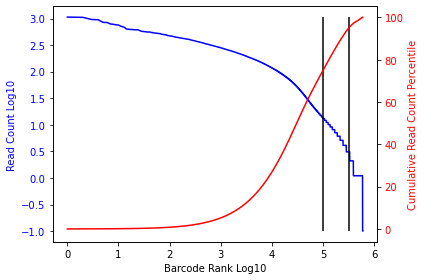

The read count cut off at the 75 th percentile is 13
The read count cut off at the 95 th percentile is 3
BB_RT_1b_340_243_Hek1053


/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


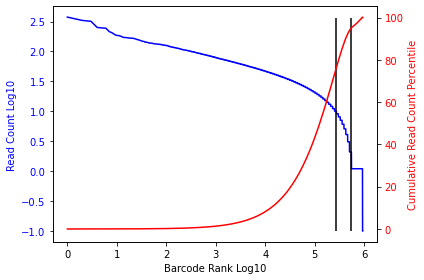

The read count cut off at the 75 th percentile is 10
The read count cut off at the 95 th percentile is 2
BB_RT_1b_340_335_Hek1053


/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


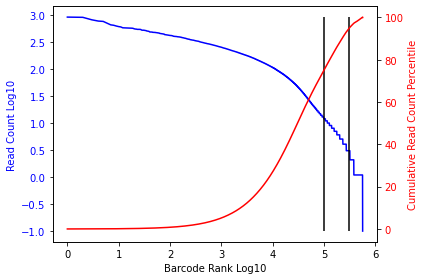

The read count cut off at the 75 th percentile is 12
The read count cut off at the 95 th percentile is 3
BB_RT_1b_ODT_243_Hek1053


/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


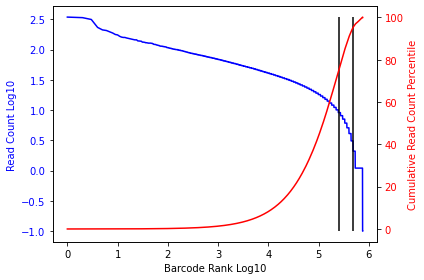

The read count cut off at the 75 th percentile is 9
The read count cut off at the 95 th percentile is 3
BB_RT_1b_ODT_335_Hek1053


/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


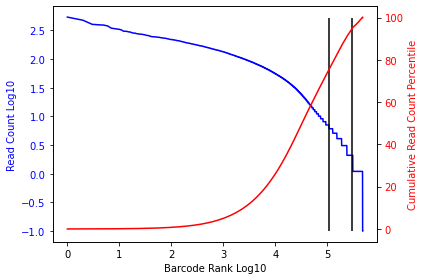

The read count cut off at the 75 th percentile is 7
The read count cut off at the 95 th percentile is 2
BB_RT_1_ODT_243_Cos1053


/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


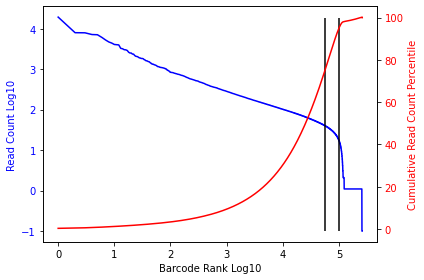

The read count cut off at the 75 th percentile is 40
The read count cut off at the 95 th percentile is 17
BB_RT_1_ODT_243_Hek1053


/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


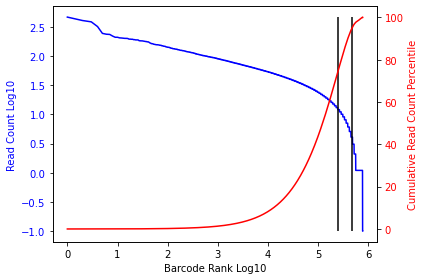

The read count cut off at the 75 th percentile is 12
The read count cut off at the 95 th percentile is 4
BB_RT_1_ODT_335_Cos1053


/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


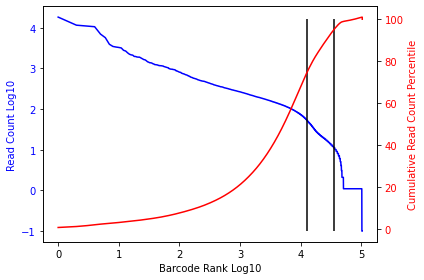

The read count cut off at the 75 th percentile is 51
The read count cut off at the 95 th percentile is 11
BB_RT_1_ODT_335_Hek1053


/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


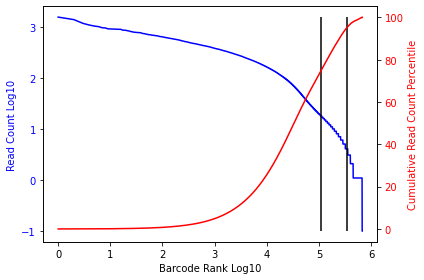

The read count cut off at the 75 th percentile is 18
The read count cut off at the 95 th percentile is 4
BB_RT_2_340_243_Cos1054


/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


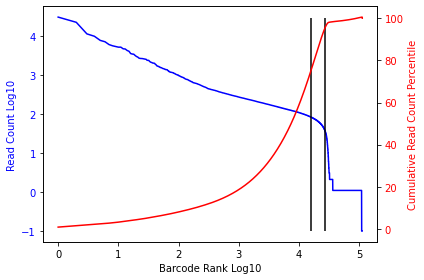

The read count cut off at the 75 th percentile is 83
The read count cut off at the 95 th percentile is 39
BB_RT_2_340_243_Hek1054


/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


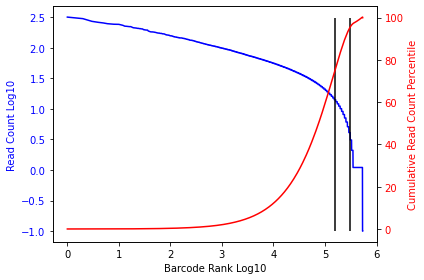

The read count cut off at the 75 th percentile is 14
The read count cut off at the 95 th percentile is 4
BB_RT_2_340_335_Cos1054


/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


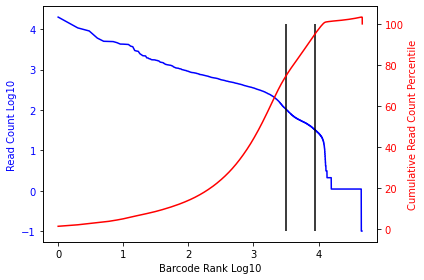

The read count cut off at the 75 th percentile is 102
The read count cut off at the 95 th percentile is 32
BB_RT_2_340_335_Hek1054


/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


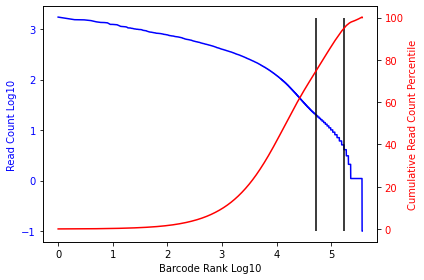

The read count cut off at the 75 th percentile is 20
The read count cut off at the 95 th percentile is 4
BB_RT_2_ODT_243_Cos1054


/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


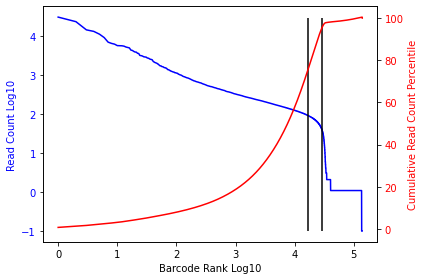

The read count cut off at the 75 th percentile is 93
The read count cut off at the 95 th percentile is 42
BB_RT_2_ODT_243_Hek1054


/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


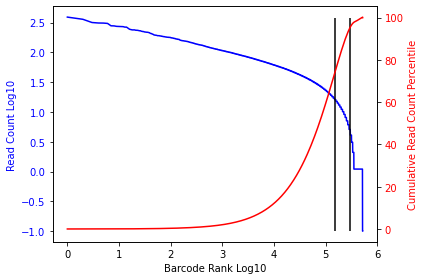

The read count cut off at the 75 th percentile is 16
The read count cut off at the 95 th percentile is 5
BB_RT_2_ODT_335_Cos1054


/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


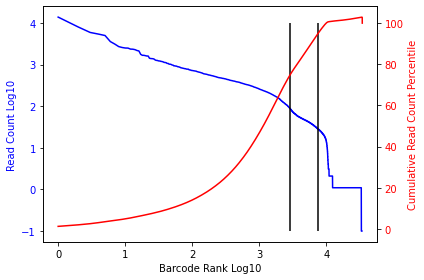

The read count cut off at the 75 th percentile is 87
The read count cut off at the 95 th percentile is 28
BB_RT_2_ODT_335_Hek1054


/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


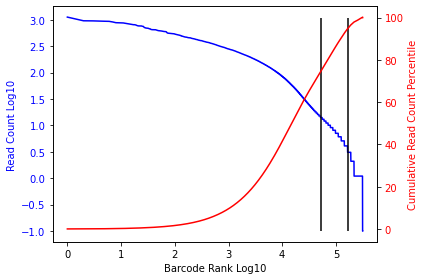

The read count cut off at the 75 th percentile is 14
The read count cut off at the 95 th percentile is 3
BB_RT_3_340_243_Cos1055


/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


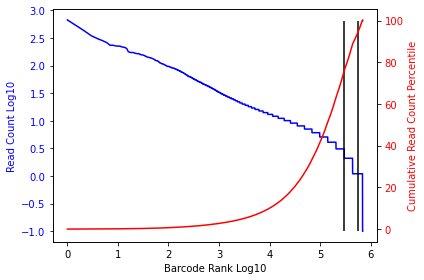

The read count cut off at the 75 th percentile is 3
The read count cut off at the 95 th percentile is 1
BB_RT_3_340_243_Hek1055


/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


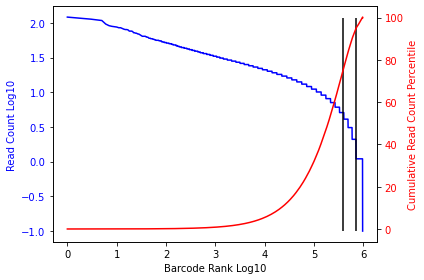

The read count cut off at the 75 th percentile is 5
The read count cut off at the 95 th percentile is 1
BB_RT_3_340_335_Cos1055


/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


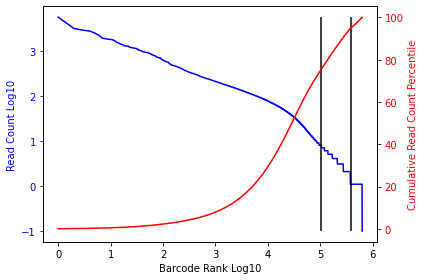

The read count cut off at the 75 th percentile is 8
The read count cut off at the 95 th percentile is 1
BB_RT_3_340_335_Hek1055


/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


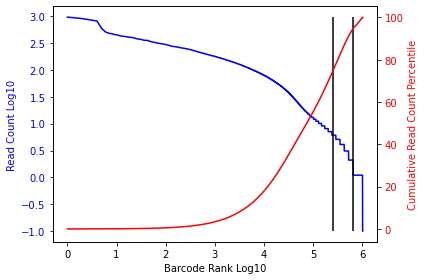

The read count cut off at the 75 th percentile is 6
The read count cut off at the 95 th percentile is 1
BB_RT_3_ODT_243_Cos1055


/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


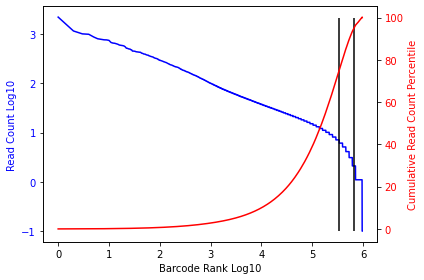

The read count cut off at the 75 th percentile is 7
The read count cut off at the 95 th percentile is 2
BB_RT_3_ODT_243_Hek1055


/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


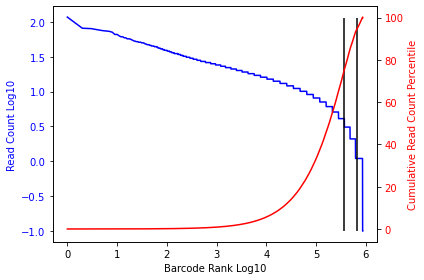

The read count cut off at the 75 th percentile is 4
The read count cut off at the 95 th percentile is 1
BB_RT_3_ODT_335_cos1055


/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


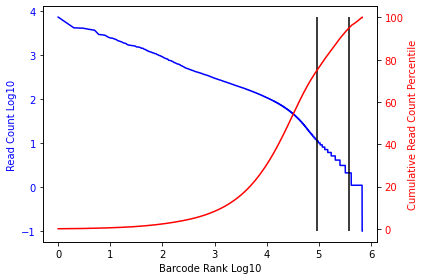

The read count cut off at the 75 th percentile is 11
The read count cut off at the 95 th percentile is 2
BB_RT_3_ODT_335_Hek1055


/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


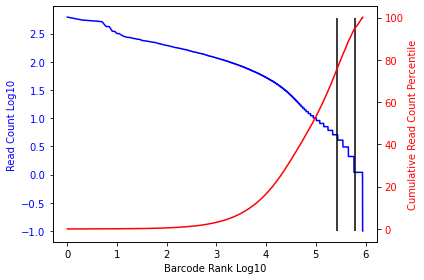

The read count cut off at the 75 th percentile is 5
The read count cut off at the 95 th percentile is 1


In [111]:
read_cut_unfilt_d = { 'sample': [],
                      '75_x': [],
                      '95_x': [],
                      '75_y': [],
                      '95_y': [], }

for samp in msamp_bcrnatbl_flen:
    
    print( samp )
    
    read_cut_unfilt_d[ 'sample' ].append( samp )
    
    x_cuts,y_cuts = sp.waterfall_plot( msamp_bcrnatbl_flen[ samp ],
                                       'usable_reads',
                                       [ 75, 95 ] )
    
    for cut in x_cuts:

        read_cut_unfilt_d[ str( cut ) + '_x' ].append( 10**( x_cuts[ cut ] ) )
        read_cut_unfilt_d[ str( cut ) + '_y' ].append( y_cuts[ cut ] )

In [112]:
read_cut_unfilt = pd.DataFrame( read_cut_unfilt_d )

In [113]:
cut_dict = { samp: cut for samp,cut in zip( read_cut_unfilt[ 'sample' ], read_cut_unfilt[ '95_y' ] ) }

In [114]:
for col in read_cut_unfilt.columns:
    
    if col.endswith( '_x' ):
        
        read_cut_unfilt[ col + '_log10' ] = np.log10( read_cut_unfilt[ col ].tolist() )

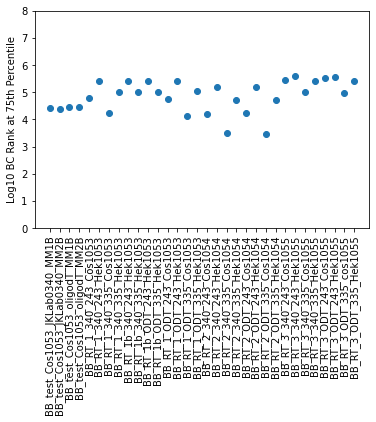

In [115]:
plt.scatter( read_cut_unfilt[ 'sample' ],
             read_cut_unfilt[ '75_x_log10' ] )

plt.xticks( rotation = 90 )

plt.ylabel( 'Log10 BC Rank at 75th Percentile' )

plt.ylim( 0, 8 )

plt.show()

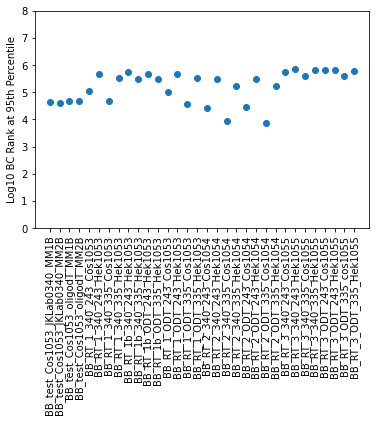

In [116]:
plt.scatter( read_cut_unfilt[ 'sample' ],
             read_cut_unfilt[ '95_x_log10' ] )

plt.xticks( rotation = 90 )

plt.ylabel( 'Log10 BC Rank at 95th Percentile' )

plt.ylim( 0, 8 )

plt.show()

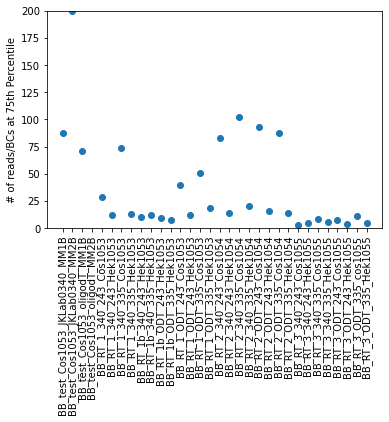

In [117]:
plt.scatter( read_cut_unfilt[ 'sample' ],
             read_cut_unfilt[ '75_y' ] )

plt.xticks( rotation = 90 )

plt.ylabel( '# of reads/BCs at 75th Percentile' )

plt.ylim( 0, 200 )

plt.show()

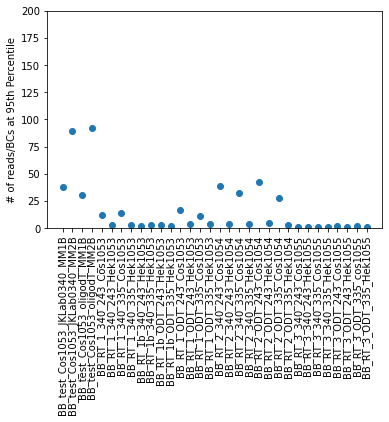

In [118]:
plt.scatter( read_cut_unfilt[ 'sample' ],
             read_cut_unfilt[ '95_y' ] )

plt.xticks( rotation = 90 )

plt.ylabel( '# of reads/BCs at 95th Percentile' )

plt.ylim( 0, 200 )

plt.show()

In [119]:
read_cut_unfilt[ 'oligoDT' ] = read_cut_unfilt[ 'sample' ].str.contains( '_ODT_' )

In [120]:
read_cut_unfilt[ 'Hek' ] = read_cut_unfilt[ 'sample' ].str.contains( '_Hek' )

In [121]:
read_cut_unfilt[ '243_synth' ] = read_cut_unfilt[ 'sample' ].str.contains( '_243_' )

In [122]:
read_cut_unfilt[ 'rep' ] = read_cut_unfilt[ 'sample' ].apply( lambda x: x.split( '_' )[ 2 ] )

In [123]:
read_cut_unfilt = read_cut_unfilt.loc[ ~( read_cut_unfilt[ 'sample' ].str.contains( 'test' ) ) ].copy()

In [124]:
read_cut_unfilt[ 'rep_num' ] = [ int( rep ) if rep != '1b' else 4 for rep in read_cut_unfilt.rep
                                 ] 

In [125]:
read_cut_unfilt

,sample,75_x,95_x,75_y,95_y,75_x_log10,95_x_log10,oligoDT,Hek,243_synth,rep,rep_num
4,BB_RT_1_340_243_Cos1053,60127.0,107182.0,29,12,4.779070,5.030122,False,False,True,1,1
5,BB_RT_1_340_243_Hek1053,251346.0,479631.0,12,3,5.400272,5.680907,False,True,True,1,1
6,BB_RT_1_340_335_Cos1053,16571.0,47962.0,74,14,4.219349,4.680897,False,False,False,1,1
7,BB_RT_1_340_335_Hek1053,100477.0,319583.0,13,3,5.002067,5.504584,False,True,False,1,1
8,BB_RT_1b_340_243_Hek1053,261519.0,539293.0,10,2,5.417503,5.731825,False,True,True,1b,4
9,BB_RT_1b_340_335_Hek1053,99627.0,312233.0,12,3,4.998377,5.494479,False,True,False,1b,4
10,BB_RT_1b_ODT_243_Hek1053,251621.0,478949.0,9,3,5.400747,5.680289,True,True,True,1b,4
11,BB_RT_1b_ODT_335_Hek1053,105322.0,302881.0,7,2,5.022519,5.481272,True,True,False,1b,4
12,BB_RT_1_ODT_243_Cos1053,56214.0,99872.0,40,17,4.749844,4.999444,True,False,True,1,1
13,BB_RT_1_ODT_243_Hek1053,251729.0,473326.0,12,4,5.400933,5.675160,True,True,True,1,1


In [126]:
read_cut_unfilt[ 'rep_2' ] = [ rep == 2 for rep in read_cut_unfilt.rep_num ]

In [127]:
read_cut_unfilt[ 'rep_1b' ] = [ rep == 4 for rep in read_cut_unfilt.rep_num ]

In [128]:
read_cut_unfilt[ 'rep_3' ] = [ rep == 3 for rep in read_cut_unfilt.rep_num ]

In [129]:
read_cut_unfilt[ '95_y' ].mean()

8.75

In [130]:
read_cut_unfilt[ '95_y' ].median()

3.0

In [131]:
predictors = [ 'oligoDT', 'Hek', '243_synth', 'rep_1b', 'rep_2', 'rep_3' ]

In [132]:
unfilt_fit = LinearRegression().fit( read_cut_unfilt[ predictors ], read_cut_unfilt[ '95_x' ] ) 

In [133]:
unfilt_fit.coef_

array([  -4311.85714286,  236882.        ,  121532.42857143,
         52306.375     , -112206.25      ,  343381.625     ])

In [ ]:
#so oligoDT results in 4360 fewer BCs,
#there are 237,000 more BCs in HEK cells,
#121,000 more BCs with 243 synthesis,
#rep1b has 52,000 more bcs that rep1
#rep2 has 112,000 fewer bcs than rep1,
#rep3 has 343,000 more bcs than rep1

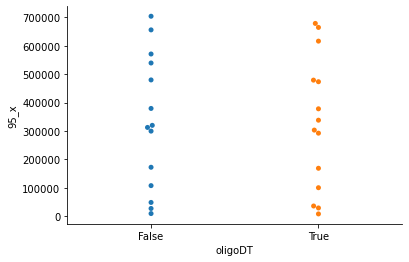

In [134]:
sns.swarmplot( x = 'oligoDT', y = '95_x', data = read_cut_unfilt )
sns.despine()

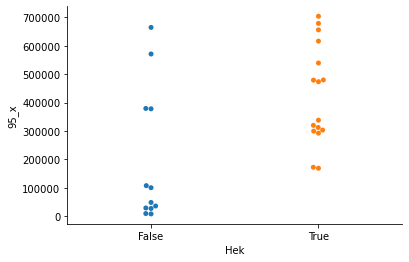

In [135]:
sns.swarmplot( x = 'Hek', y = '95_x', data = read_cut_unfilt )
sns.despine()

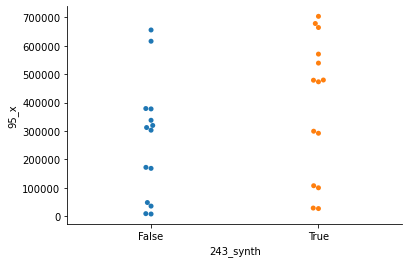

In [136]:
sns.swarmplot( x = '243_synth', y = '95_x', data = read_cut_unfilt )
sns.despine()

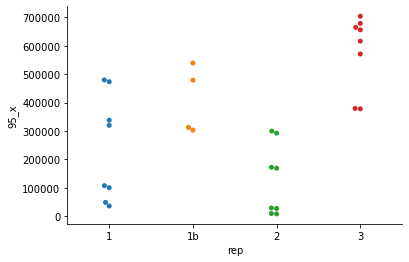

In [137]:
sns.swarmplot( x = 'rep', y = '95_x', data = read_cut_unfilt )
sns.despine()

In [138]:
read_cut_unfilt[ 'primer' ] = [ 'oligoDT' if oligo else '340' for oligo in read_cut_unfilt.oligoDT ]

In [139]:
read_cut_unfilt[ 'cell_type' ] = [ 'HEK' if hek else 'Cos' for hek in read_cut_unfilt.Hek ]

In [140]:
read_cut_unfilt[ 'synthesis' ] = [ '243' if synth else '335' for synth in read_cut_unfilt[ '243_synth' ] ]

In [141]:
read_cut_unfilt.to_csv( bdout + 'n_bcs_bysamp.2022-0609.txt',
                        sep = '\t',
                        index = False )

In [ ]:
msamp_varbcrnatbl_flen_allisos = { lib: { samp: mbcs.merge_subasm_and_rna_tbls( satbl_fn[ lib ],
                                                                                msamp_bcrnatbl_flen[ samp ] )
                                           for samp in msamp_bcrnatbl_flen
                                           if lib.replace( 'JKP', '' ) in samp }
                                   for lib in satbl_fn }

In [ ]:
msamp_varbcrnatbl_flen_allisos[ 'JKP1053' ][ 'BB_test_Cos1053_JKLab0340_MM1B' ].head()

In [ ]:
%%time
for lib in msamp_varbcrnatbl_flen_allisos:

    for samp in msamp_varbcrnatbl_flen_allisos[ lib ]:
    
        msamp_varbcrnatbl_flen_allisos[ lib ][ samp ].to_csv( bdout + samp + '_wt1_ex9_by_bc_effects_allvars_allisos-2022-0609.txt',
                                                               sep='\t'
                                                              )

In [ ]:
isonamedict = { 'KTS+': [ (1267, 1359) ],
                'KTS-': [ (1267, 1350) ],
                'SKIP': [] }

In [ ]:
namedisogrps = { samp: jn.create_named_isogrps( isogrpdict[ samp ],
                                                isonamedict,
                                                [],
                                                28,
                                                150,
                                                3 )
                for samp in isogrpdict }

In [ ]:
msamp_bcrnatbl_flen_rename = { samp: jn.combine_isogrps_pe( namedisogrps[ samp ],
                                                            msamp_bcrnatbl_flen[ samp ] ) 
                               for samp in namedisogrps }

In [ ]:
msamp_bcrnatbl_flen_rename[ 'BB_test_Cos1053_JKLab0340_MM1B' ]

In [ ]:
msamp_varbcrnatbl_flen_rename = { lib: { samp: mbcs.merge_subasm_and_rna_tbls( satbl_fn[ lib ],
                                                                                msamp_bcrnatbl_flen_rename[ samp ] )
                                          for samp in msamp_bcrnatbl_flen_rename
                                          if lib.replace( 'JKP', '' ) in samp }
                                  for lib in satbl_fn }

In [ ]:
msamp_varbcrnatbl_flen_rename[ 'JKP1053' ][ 'BB_test_Cos1053_JKLab0340_MM1B' ]

In [ ]:
msamp_varbcrnatbl_flen_rename_filt = { lib: { samp: msamp_varbcrnatbl_flen_rename[ lib ][ samp ].loc[ msamp_varbcrnatbl_flen_rename[ lib ][ samp ].usable_reads > cut_dict[ samp ] ].copy()
                                              for samp in msamp_varbcrnatbl_flen_rename[ lib ] } 
                                       for lib in msamp_varbcrnatbl_flen_rename }

In [ ]:
%%time
bybcvartbl_filt_long = { lib: mbcs.combine_rep_perbctbls_long( [ msamp_varbcrnatbl_flen_rename_filt[ lib ][ samp ] for samp in msamp_varbcrnatbl_flen_rename_filt[ lib ] ],
                                                          [ samp for samp in msamp_varbcrnatbl_flen_rename_filt[ lib ] ] )
                    for lib in msamp_varbcrnatbl_flen_rename_filt }

BB_test_Cos1053_JKLab0340_MM1B


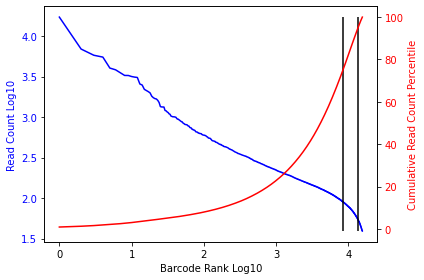

The read count cut off at the 75 th percentile is 90
The read count cut off at the 95 th percentile is 54
BB_test_Cos1053_JKLab0340_MM2B


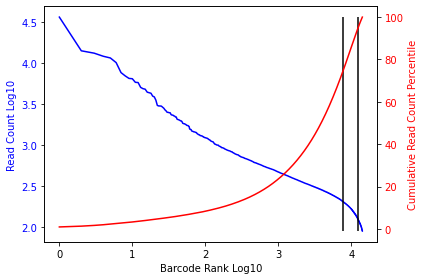

The read count cut off at the 75 th percentile is 204
The read count cut off at the 95 th percentile is 125
BB_test_Cos1053_oligodT_MM1B


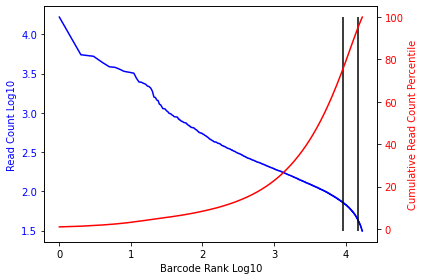

The read count cut off at the 75 th percentile is 72
The read count cut off at the 95 th percentile is 43
BB_test_Cos1053_oligodT_MM2B


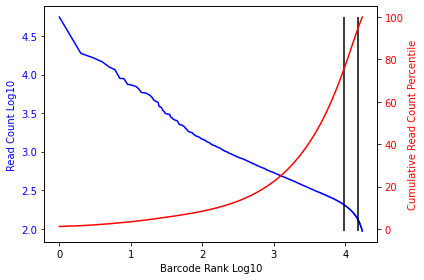

The read count cut off at the 75 th percentile is 206
The read count cut off at the 95 th percentile is 129
BB_RT_1_340_243_Cos1053


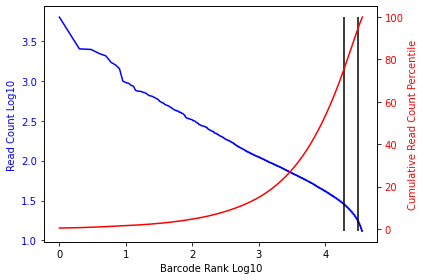

The read count cut off at the 75 th percentile is 29
The read count cut off at the 95 th percentile is 17
BB_RT_1_340_243_Hek1053


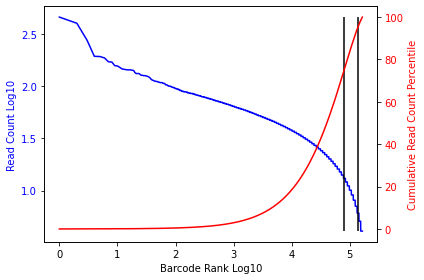

The read count cut off at the 75 th percentile is 13
The read count cut off at the 95 th percentile is 6
BB_RT_1_340_335_Cos1053


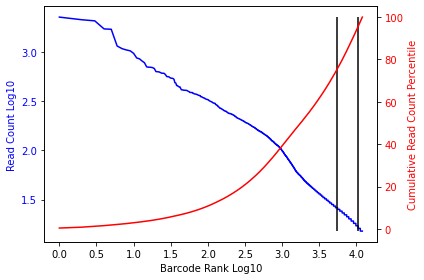

The read count cut off at the 75 th percentile is 26
The read count cut off at the 95 th percentile is 17
BB_RT_1_340_335_Hek1053


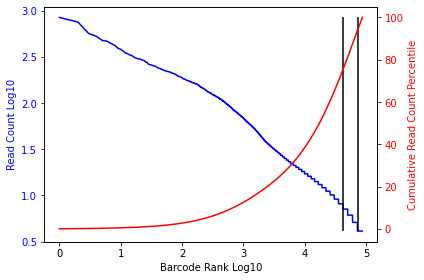

The read count cut off at the 75 th percentile is 8
The read count cut off at the 95 th percentile is 4
BB_RT_1b_340_243_Hek1053


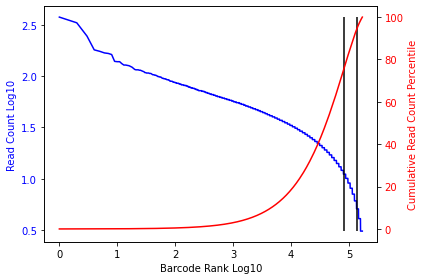

The read count cut off at the 75 th percentile is 11
The read count cut off at the 95 th percentile is 5
BB_RT_1b_340_335_Hek1053


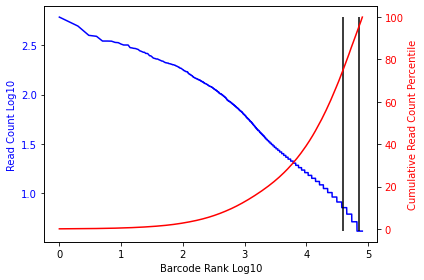

The read count cut off at the 75 th percentile is 7
The read count cut off at the 95 th percentile is 4
BB_RT_1b_ODT_243_Hek1053


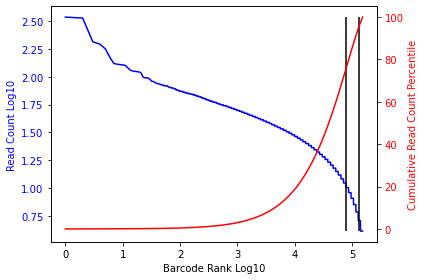

The read count cut off at the 75 th percentile is 11
The read count cut off at the 95 th percentile is 5
BB_RT_1b_ODT_335_Hek1053


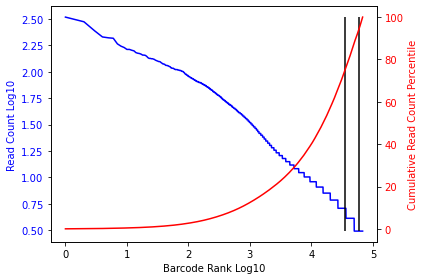

The read count cut off at the 75 th percentile is 5
The read count cut off at the 95 th percentile is 3
BB_RT_1_ODT_243_Cos1053


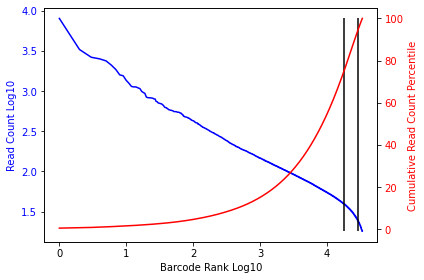

The read count cut off at the 75 th percentile is 39
The read count cut off at the 95 th percentile is 24
BB_RT_1_ODT_243_Hek1053


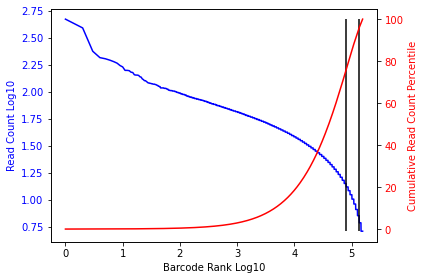

The read count cut off at the 75 th percentile is 14
The read count cut off at the 95 th percentile is 7
BB_RT_1_ODT_335_Cos1053


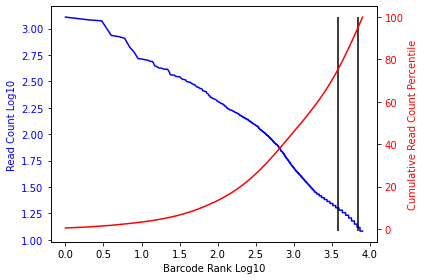

The read count cut off at the 75 th percentile is 20
The read count cut off at the 95 th percentile is 13
BB_RT_1_ODT_335_Hek1053


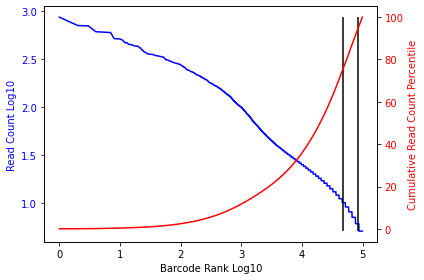

The read count cut off at the 75 th percentile is 10
The read count cut off at the 95 th percentile is 6
BB_RT_2_340_243_Cos1054


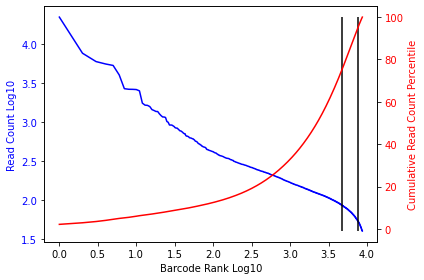

The read count cut off at the 75 th percentile is 86
The read count cut off at the 95 th percentile is 54
BB_RT_2_340_243_Hek1054


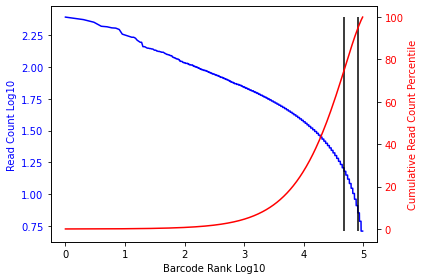

The read count cut off at the 75 th percentile is 15
The read count cut off at the 95 th percentile is 7
BB_RT_2_340_335_Cos1054


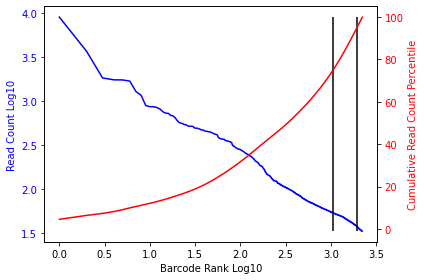

The read count cut off at the 75 th percentile is 53
The read count cut off at the 95 th percentile is 37
BB_RT_2_340_335_Hek1054


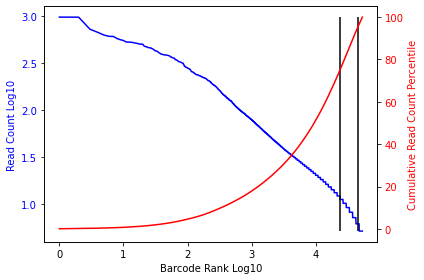

The read count cut off at the 75 th percentile is 12
The read count cut off at the 95 th percentile is 6
BB_RT_2_ODT_243_Cos1054


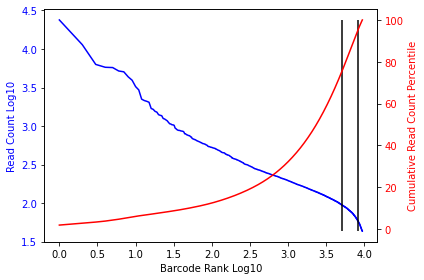

The read count cut off at the 75 th percentile is 95
The read count cut off at the 95 th percentile is 59
BB_RT_2_ODT_243_Hek1054


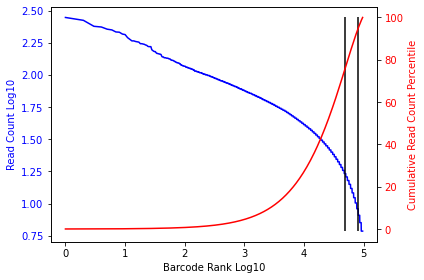

The read count cut off at the 75 th percentile is 17
The read count cut off at the 95 th percentile is 8
BB_RT_2_ODT_335_Cos1054


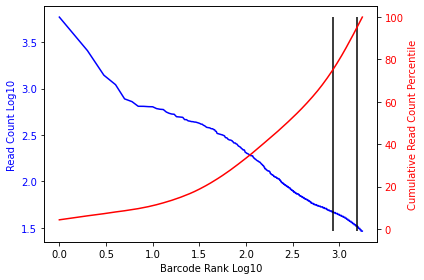

The read count cut off at the 75 th percentile is 47
The read count cut off at the 95 th percentile is 33
BB_RT_2_ODT_335_Hek1054


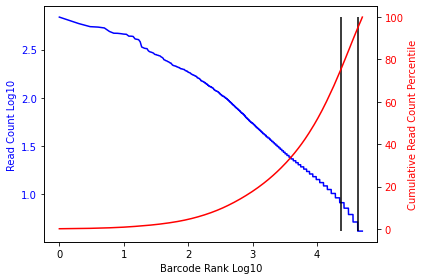

The read count cut off at the 75 th percentile is 8
The read count cut off at the 95 th percentile is 4
BB_RT_3_340_243_Cos1055


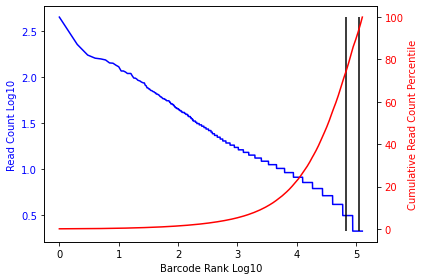

The read count cut off at the 75 th percentile is 3
The read count cut off at the 95 th percentile is 2
BB_RT_3_340_243_Hek1055


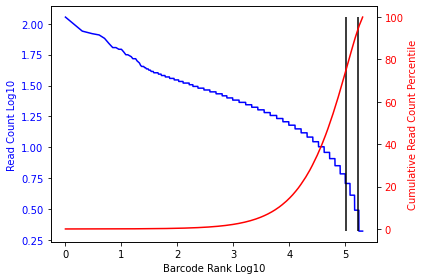

The read count cut off at the 75 th percentile is 5
The read count cut off at the 95 th percentile is 3
BB_RT_3_340_335_Cos1055


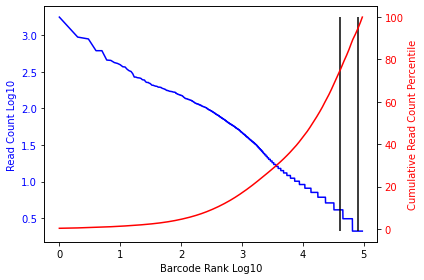

The read count cut off at the 75 th percentile is 4
The read count cut off at the 95 th percentile is 2
BB_RT_3_340_335_Hek1055


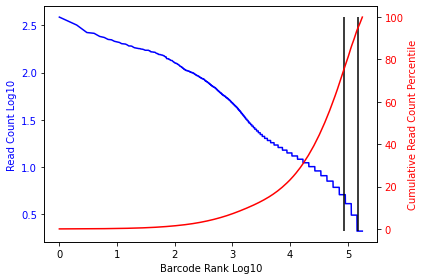

The read count cut off at the 75 th percentile is 5
The read count cut off at the 95 th percentile is 2
BB_RT_3_ODT_243_Cos1055


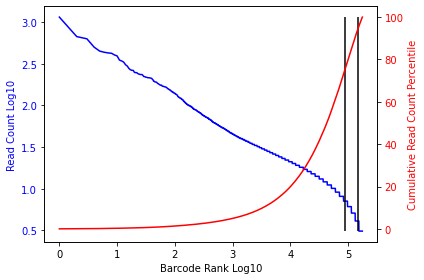

The read count cut off at the 75 th percentile is 7
The read count cut off at the 95 th percentile is 4
BB_RT_3_ODT_243_Hek1055


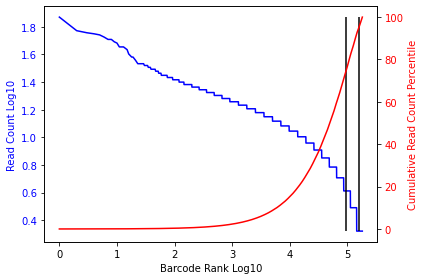

The read count cut off at the 75 th percentile is 4
The read count cut off at the 95 th percentile is 2
BB_RT_3_ODT_335_cos1055


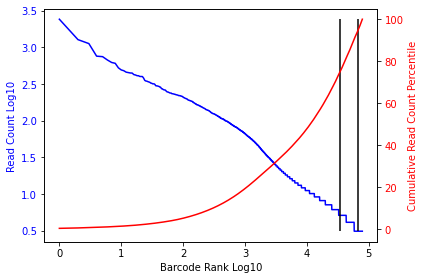

The read count cut off at the 75 th percentile is 5
The read count cut off at the 95 th percentile is 3
BB_RT_3_ODT_335_Hek1055


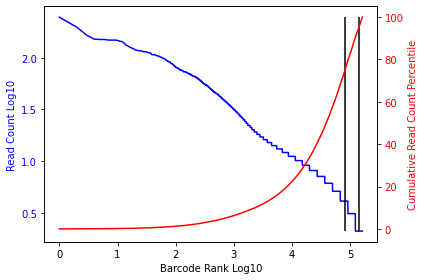

The read count cut off at the 75 th percentile is 4
The read count cut off at the 95 th percentile is 2


In [142]:
read_cut_filt_d = { 'sample': [],
                      '75_x': [],
                      '95_x': [],
                      '75_y': [],
                      '95_y': [], }

for lib in bybcvartbl_filt_long:

    for samp in bybcvartbl_filt_long[ lib ][ 'sample' ].unique():
    
        print( samp )
    
        read_cut_filt_d[ 'sample' ].append( samp )
    
        x_cuts,y_cuts = sp.waterfall_plot( bybcvartbl_filt_long[ lib ].loc[ bybcvartbl_filt_long[ lib ][ 'sample' ] == samp ],
                                           'usable_reads',
                                           [ 75, 95 ] )
    
        for cut in x_cuts:

            read_cut_filt_d[ str( cut ) + '_x' ].append( 10**( x_cuts[ cut ] ) )
            read_cut_filt_d[ str( cut ) + '_y' ].append( y_cuts[ cut ] )

In [143]:
read_cut_filt = pd.DataFrame( read_cut_filt_d )

In [144]:
for col in read_cut_filt.columns:
    
    if col.endswith( '_x' ):
        
        read_cut_filt[ col + '_log10' ] = np.log10( read_cut_filt[ col ].tolist() )

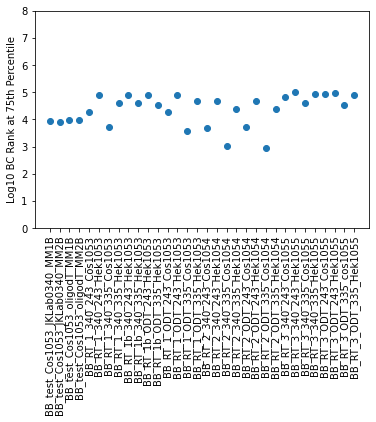

In [145]:
plt.scatter( read_cut_filt[ 'sample' ],
             read_cut_filt[ '75_x_log10' ] )

plt.xticks( rotation = 90 )

plt.ylabel( 'Log10 BC Rank at 75th Percentile' )

plt.ylim( 0, 8 )

plt.show()

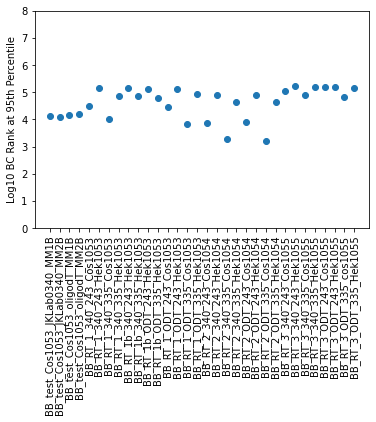

In [146]:
plt.scatter( read_cut_filt[ 'sample' ],
             read_cut_filt[ '95_x_log10' ] )

plt.xticks( rotation = 90 )

plt.ylabel( 'Log10 BC Rank at 95th Percentile' )

plt.ylim( 0, 8 )

plt.show()

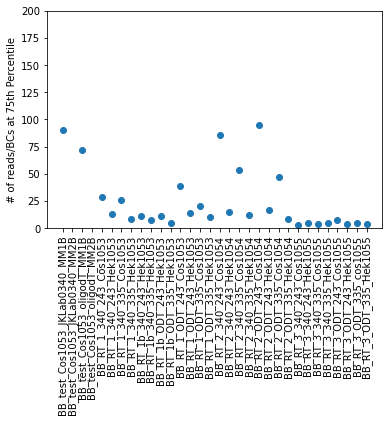

In [147]:
plt.scatter( read_cut_filt[ 'sample' ],
             read_cut_filt[ '75_y' ] )

plt.xticks( rotation = 90 )

plt.ylabel( '# of reads/BCs at 75th Percentile' )

plt.ylim( 0, 200 )

plt.show()

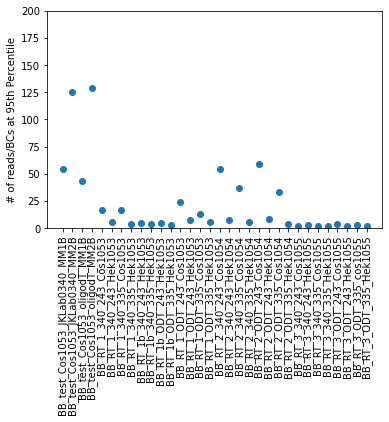

In [148]:
plt.scatter( read_cut_filt[ 'sample' ],
             read_cut_filt[ '95_y' ] )

plt.xticks( rotation = 90 )

plt.ylabel( '# of reads/BCs at 95th Percentile' )

plt.ylim( 0, 200 )

plt.show()

In [149]:
read_cut_filt.to_csv( bdout + 'n_bcs_passfilt_bysamp.2022-0609.txt',
                        sep = '\t',
                        index = False )

In [ ]:
%%time
bybcvartbl_long = { lib: mbcs.combine_rep_perbctbls_long( [ msamp_varbcrnatbl_flen_rename[ lib ][ samp ] for samp in msamp_varbcrnatbl_flen_rename[ lib ] ],
                                                          [ samp for samp in msamp_varbcrnatbl_flen_rename[ lib ] ] )
                    for lib in msamp_varbcrnatbl_flen_rename }

In [ ]:
bybcvartbl_long[ 'JKP1053' ]

In [ ]:
for lib in satbl_fn:
    
    bybcvartbl_long[ lib ].to_csv( bdout + 'wt1_ex9_%s_by_bc_effects_allvars-2022-0609.txt' % lib,
                                    sep='\t'
                                 )

In [ ]:
%%time
msamp_byvartbl_allisos = { lib: { samp: mbcs.summarize_byvar_singlevaronly_pe( satbl_fn[ lib ],
                                                                              msamp_bcrnatbl_flen[ samp ],
                                                                              [ (1267, 1359) ],
                                                                              cut_dict[ samp ],
                                                                              [ 'secondary_reads', 'unpaired_reads', 'unmapped_reads', 'bad_starts', 'bad_ends', 'soft_clipped', 'other_isoform', 'usable_reads', ] )
                                   for samp in msamp_bcrnatbl
                                   if lib.replace( 'JKP', '' ) in samp }
                          for lib in satbl_fn }

In [ ]:
msamp_byvartbl_allisos_snvs = { lib: { samp: mbcs.filter_byvartbl_snvonly( msamp_byvartbl_allisos[ lib ][ samp ] )
                                        for samp in msamp_byvartbl_allisos[ lib ] }
                                for lib in msamp_byvartbl_allisos }

In [ ]:
msamp_byvartbl_allisos_snvs[ 'JKP1053' ][ 'BB_test_Cos1053_JKLab0340_MM1B' ].head() 

In [ ]:
for lib in msamp_byvartbl_allisos_snvs:

    for samp in msamp_byvartbl_allisos_snvs[ lib ]:

        msamp_byvartbl_allisos_snvs[ lib ][ samp ][ 'hgvs_pos' ] = cds.pos_to_hgvspos( msamp_byvartbl_allisos_snvs[ lib ][ samp ].pos,
                                                                                        ( 1058, 1554 ),
                                                                                        [ (1267, 1359) ],
                                                                                        [ ( 1355, 1447 ), ]
                                                                                     )

In [ ]:
lib_byvartbl_allisos_long = { lib: mbcs.combine_allisos_pervartbls_long( [ msamp_byvartbl_allisos_snvs[ lib ][ samp ] for samp in msamp_byvartbl_allisos_snvs[ lib ] ],
                                                                      [ samp for samp in msamp_byvartbl_allisos_snvs[ lib ] ] )
                              for lib in msamp_byvartbl_allisos_snvs } 

In [ ]:
for lib in lib_byvartbl_allisos_long:
    
    lib_byvartbl_allisos_long[ lib ].to_csv( bdout + 'wt1_ex9_%s_by_var_effects_allisos_snvs-2022-0609.txt' % lib,
                                              sep = '\t',
                                              index = False
                                            )

In [ ]:
byvartbl_allisos_long = pd.concat( [ lib_byvartbl_allisos_long[ lib ] for lib in lib_byvartbl_allisos_long ] )

In [ ]:
byvartbl_allisos_long

In [ ]:
byvartbl_allisos_long.to_csv( bdout + 'wt1_ex9_by_var_effects_allisos_snvs-2022-0609.txt',
                                              sep = '\t',
                                              index = False
                                            )

In [ ]:
%%time
msamp_byvartbl = { lib: { samp: mbcs.summarize_byvar_singlevaronly_pe( satbl_fn[ lib ],
                                                                       msamp_bcrnatbl_flen_rename[ samp ],
                                                                       [ ( 1267, 1359 ) ],
                                                                      cut_dict[ samp ],
                                                                     [ 'secondary_reads', 'unpaired_reads', 'unmapped_reads', 'bad_starts', 'bad_ends', 'soft_clipped', 'other_isoform', 'usable_reads', ],
                                                                     [ 'KTS+', 'KTS-', 'SKIP', 'OTHER' ] )
                           for samp in msamp_bcrnatbl_flen_rename
                           if lib.replace( 'JKP', '' ) in samp }
                 for lib in satbl_fn } 

In [ ]:
msamp_bcrnatbl_flen_rename[ 'BB_test_Cos1053_JKLab0340_MM1B' ].head()

In [ ]:
msamp_byvartbl_snvs = { lib: { samp: mbcs.filter_byvartbl_snvonly( msamp_byvartbl[ lib ][ samp ] )
                                  for samp in msamp_byvartbl[ lib ] }
                        for lib in msamp_byvartbl }

In [ ]:
for lib in msamp_byvartbl_snvs:

    for samp in msamp_byvartbl_snvs[ lib ]:

        msamp_byvartbl_snvs[ lib ][ samp ][ 'hgvs_pos' ] = cds.pos_to_hgvspos( msamp_byvartbl_snvs[ lib ][ samp ].pos,
                                                                               ( 1058, 1554 ),
                                                                                [ (1267, 1359) ],
                                                                                [ ( 1355, 1447 ), ]
                                                                              )

In [ ]:
#last bp of exon is 32413518
#first bp of exon is 32413610
for lib in msamp_byvartbl_snvs:

    for samp in msamp_byvartbl_snvs[ lib ]:

        msamp_byvartbl_snvs[ lib ][ samp ][ 'hg19_pos' ] = cds.vpos_to_gpos( msamp_byvartbl_snvs[ lib ][ samp ].pos,
                                                                              ( 1058, 1554 ),
                                                                              [ 32413323, 32413819 ] ,
                                                                              rev_strand = True
                                                                             )

In [ ]:
lib_byvartbl_long = { lib: mbcs.combine_rep_pervartbls_long( [ msamp_byvartbl_snvs[ lib ][ samp ] for samp in msamp_byvartbl_snvs[ lib ] ],
                                                              [ samp for samp in msamp_byvartbl_snvs[ lib ] ] )
                      for lib in msamp_byvartbl_snvs }

In [ ]:
for lib in lib_byvartbl_long:

    lib_byvartbl_long[ lib ].to_csv( bdout + 'wt1_ex9_%s_by_var_effects_snvs-2022-0609.txt' % lib,
                                      sep = '\t',
                                      index = False )

In [ ]:
lib_byvartbl_long[ 'JKP1053' ]

In [ ]:
byvartbl_long = pd.concat( [ lib_byvartbl_long[ lib ] for lib in lib_byvartbl_long ] )

In [ ]:
byvartbl_long[ 'exon_num' ] = '9'

In [ ]:
byvartbl_long[ 'ref_c' ] = byvartbl_long.ref

In [ ]:
byvartbl_long[ 'alt_c' ] = byvartbl_long.alt

In [ ]:
byvartbl_long[ 'ref' ] = [ css.rev_complement( r ) for r in byvartbl_long.ref_c ]

In [ ]:
byvartbl_long[ 'alt' ] = [ css.rev_complement( a ) for a in byvartbl_long.alt_c ]

In [ ]:
byvartbl_long.to_csv( bdout + 'wt1_ex9_by_var_effects_snvs-2022-0609.txt',
                      sep = '\t',
                      index = False )